In [113]:
import pandas as pd
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import concurrent.futures
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterSampler
from sklearn.base import BaseEstimator
from sklearn.model_selection import RandomizedSearchCV, KFold, LeaveOneOut
from datetime import timedelta

In [2]:
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)  

In [3]:
df = pd.read_parquet('COMPRESSED_CIS_tle_data.parquet')
df.shape

(3030409, 31)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3030409 entries, 0 to 3030408
Data columns (total 31 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   idElset                object 
 1   classificationMarking  object 
 2   satNo                  int64  
 3   epoch                  object 
 4   meanMotion             float64
 5   idOnOrbit              object 
 6   eccentricity           float64
 7   inclination            float64
 8   raan                   float64
 9   argOfPerigee           float64
 10  meanAnomaly            float64
 11  revNo                  int64  
 12  bStar                  float64
 13  meanMotionDot          float64
 14  meanMotionDDot         float64
 15  semiMajorAxis          float64
 16  period                 float64
 17  apogee                 float64
 18  perigee                float64
 19  line1                  object 
 20  line2                  object 
 21  createdAt              object 
 22  createdBy         

**Describe the fields:**

0. idElset: A unique identifier for each satellite element set. Object data type.

1. classificationMarking: Indicates the classification of the satellite data, where "U" stands for unclassified. Object data type.

2. satNo: The satellite number, a unique identifier for a satellite. Interger data type.

3. epoch: The timestamp indicating when the satellite's position and orbital elements were recorded. This is in UTC format. Currently as object data type.

4. meanMotion: The number of revolutions the satellite completes around the earth per day. This parameter gives an idea of the speed at which the satellite orbits the earth. 64-bit floating-point number.

5. idOnOrbit: A repeat of the satellite number (satNo), possibly for consistency across different data sources. Object data type.

6. eccentricity: A measure of how much the satellite's orbit deviates from a perfect circle. Values closer to 0 indicate a more circular orbit, while values closer to 1 indicate a more elliptical orbit. 64-bit floating-point number.

7. inclination: The angle between the satellite's orbital plane and the Earth's equator, measured in degrees. It indicates how far north or south the satellite travels relative to the equator. 64-bit floating-point number.

8. raan (Right Ascension of the Ascending Node): The angle, measured from a fixed point in the sky, representing where the satellite crosses the equator from the southern hemisphere to the northern hemisphere. 64-bit floating-point number.

9. argOfPerigee (Argument of Perigee): The angle within the satellite's orbital plane that defines the point where the satellite is closest to the Earth (perigee). 64-bit floating-point number.

10. meanAnomaly: An angular parameter that helps describe the position of the satellite along its orbit at a specific time. 64-bit floating-point number.

11. revNo: The revolution number of the satellite, indicating the number of complete orbits made by the satellite since launch. An interger data type.

12. bStar: A drag term used in the satellite's orbital model to account for atmospheric drag affecting the satellite’s motion, particularly in lower orbits. 64-bit floating-point number.

13. meanMotionDot: The first derivative of the mean motion, representing how the satellite’s speed is changing over time, which might be due to perturbing forces like gravitational effects. 64-bit floating-point number.

14. meanMotionDDot: The second derivative of the mean motion, further describing changes in the satellite’s speed, providing more detailed information about the satellite's acceleration or deceleration. 64-bit floating-point number.

15. semiMajorAxis: The distance from the center of the satellite's orbit to its farthest point, measured in kilometers. This value is important for describing the size of the satellite's orbit. 64-bit floating-point number.

16. period: The time it takes for the satellite to complete one full orbit around the Earth, measured in minutes. 64-bit floating-point number.

17. apogee: The highest point in the satellite's orbit, i.e., the farthest distance from the Earth during its orbit. 64-bit floating-point number.

18. perigee: The lowest point in the satellite's orbit, i.e., the closest distance to the Earth during its orbit. 64-bit floating-point number.

19. line1: A string representing the first line of a Two-Line Element (TLE) format, which contains information about the satellite's orbit. Object data type.

20. line2: A string representing the second line of a TLE format, which includes additional details about the satellite's orbital elements. Object data type.

21. createdAt: The timestamp indicating when this specific record or data entry was created. Object data type.

22. createdBy: The identifier for the system or person responsible for generating this specific record. Object data type.

23. source: The organization or system that provided the satellite data. In this case, "18th SPCS" refers to the 18th Space Control Squadron, which tracks space objects. Object data type.

24. dataMode: Describes the type or mode of data being used or collected. For example, 'REAL' might indicate real-time or current data. Object data type.

25. origNetwork: Likely identifies the network or system through which the data was originally collected or processed. Object data type.

26. algorithm: The algorithm used to process or analyze the satellite data. In this case, 'SGP4' refers to the Simplified General Perturbations model, which is a commonly used orbital model for predicting satellite positions. Object data type.

27. sourceDL: Possibly refers to additional details or metadata about the data source, though it’s marked as None in the provided example. Object data type.

28. ephemType: Likely refers to the type of ephemeris (data that provides the positions of astronomical objects), though it is marked as NaN in this example. 64-bit floating-point number. 

29. uct: May refer to Universal Coordinated Time (UTC), though this column is marked as None in the example provided. Object data type.

30. descriptor: Additional descriptive information about the satellite or data, though it is marked as None in this case. Object data type.

In [8]:
# Load the CIS_satcat.pkl dataset
file_path = r'C:\Users\megan\OneDrive\Desktop\Data_Analytics\CIS 831A\Project\CIS831_russat-main\output\CIS_satcat.pkl'

with open(file_path, 'rb') as f:
    satcat = pickle.load(f)

# Convert the satcat data into a DataFrame for easy manipulation
satcat_df = pd.DataFrame(satcat)

# Load the UCS-Satellite-Database 5-1-2023.xlsx dataset
file_path_ucs = r'C:\Users\megan\OneDrive\Desktop\Data_Analytics\CIS 831A\Project\CIS831_russat-main\notebooks\UCS-Satellite-Database 5-1-2023.xlsx'
ucs_df = pd.read_excel(file_path_ucs)

# Ensure 'NORAD_CAT_ID' and 'satNo' are the same type, converting both to integers
satcat_df['NORAD_CAT_ID'] = satcat_df['NORAD_CAT_ID'].astype(int)
df['satNo'] = df['satNo'].astype(int)
ucs_df['NORAD Number'] = ucs_df['NORAD Number'].astype(int)

# Merge the original dataset with the new data on 'satNo' and 'NORAD_CAT_ID'
# Keep only the 'COUNTRY' and 'OBJECT_TYPE' field from the new data
enriched_df = pd.merge(df, satcat_df[['NORAD_CAT_ID', 'COUNTRY', 'OBJECT_TYPE']], 
                       how='inner', left_on='satNo', right_on='NORAD_CAT_ID')

enriched_df = pd.merge(enriched_df, ucs_df[['NORAD Number', 'Country of Operator/Owner', 'Purpose']],
                       how='left', left_on='satNo', right_on='NORAD Number')

# Filter to include only 'CIS' country and 'ROCKET BODY' or 'PAYLOAD'
filtered_df = enriched_df[(enriched_df['COUNTRY'] == 'CIS') & 
                          (enriched_df['OBJECT_TYPE'].isin(['PAYLOAD']) &
                          (enriched_df['Country of Operator/Owner'] == 'Russia'))]

# Apply the orbital features filter to select only the relevant columns
orbital_features = [
    'epoch', 'meanMotion', 'eccentricity', 'inclination', 
    'raan', 'argOfPerigee', 'meanAnomaly', 'meanMotionDot', 
    'meanMotionDDot', 'semiMajorAxis', 'apogee', 'perigee'
]

# Add the necessary columns for identification (e.g., 'satNo', 'COUNTRY', 'OBJECT_TYPE')
necessary_columns = ['satNo', 'COUNTRY', 'OBJECT_TYPE',
                     'Country of Operator/Owner', 'Purpose'] + orbital_features

# Filter the DataFrame to keep only the necessary columns
filtered_df = filtered_df[necessary_columns]

# Drop Duplications
filtered_df = filtered_df.drop_duplicates()

# Display the filtered data to ensure it worked
filtered_df.head()

satNo COUNTRY OBJECT_TYPE Country of Operator/Owner            Purpose                        epoch  meanMotion  eccentricity  inclination     raan  argOfPerigee  meanAnomaly  meanMotionDot  meanMotionDDot  semiMajorAxis    apogee   perigee
3559  41386     CIS     PAYLOAD                    Russia  Earth Observation  2023-10-14T12:05:14.817408Z   15.824571      0.000294      97.1681  19.3954       43.0285     317.1214       0.001123             0.0       6701.631  6703.602  6699.661
3560  41386     CIS     PAYLOAD                    Russia  Earth Observation  2023-10-17T06:51:10.448640Z   15.829922      0.000294      97.1662  22.2995       32.3604     327.7846       0.000898             0.0       6700.121  6702.088  6698.154
3561  41386     CIS     PAYLOAD                    Russia  Earth Observation  2023-10-15T21:28:22.646784Z   15.827299      0.000291      97.1670  20.8475       37.2314     322.9157       0.000976             0.0       6700.862  6702.809  6698.914
3562  41386     CIS     PAYLOAD                    Russia  Earth Observation  2023-10-16T05:03:35.242848Z   15.827951      0.000289      97.1668  21.1774       37.1818     322.9650       0.001017             0.0       6700.677  6702.611  6698.744
3563  41386     CIS     PAYLOAD                    Russia  Earth Observation  2023-10-16T08:05:40.009632Z   15.828164      0.000290      97.1667  21.3096       37.0084     323.1385       0.000976             0.0       6700.617  6702.560  6698.674

In [9]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147263 entries, 3559 to 3023033
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   satNo                      147263 non-null  int32  
 1   COUNTRY                    147263 non-null  object 
 2   OBJECT_TYPE                147263 non-null  object 
 3   Country of Operator/Owner  147263 non-null  object 
 4   Purpose                    147263 non-null  object 
 5   epoch                      147263 non-null  object 
 6   meanMotion                 147263 non-null  float64
 7   eccentricity               147263 non-null  float64
 8   inclination                147263 non-null  float64
 9   raan                       147263 non-null  float64
 10  argOfPerigee               147263 non-null  float64
 11  meanAnomaly                147263 non-null  float64
 12  meanMotionDot              147263 non-null  float64
 13  meanMotionDDot             147

In [10]:
# Filter filtered_df to include only rows where Purpose is "Navigation/Global Positioning"
RU_PNT_SAT = filtered_df[filtered_df['Purpose'] == "Navigation/Global Positioning"]

# Display the filtered data to ensure it worked
RU_PNT_SAT.head()

satNo COUNTRY OBJECT_TYPE Country of Operator/Owner                        Purpose                        epoch  meanMotion  eccentricity  inclination      raan  argOfPerigee  meanAnomaly  meanMotionDot  meanMotionDDot  semiMajorAxis     apogee    perigee
29711  29671     CIS     PAYLOAD                    Russia  Navigation/Global Positioning  2024-01-21T00:52:42.563136Z    2.129632      0.002103      64.7108  223.7708      176.0106     185.7700   1.120000e-06             0.0      25519.108  25572.772  25465.444
29712  29671     CIS     PAYLOAD                    Russia  Navigation/Global Positioning  2024-09-30T08:13:07.427712Z    2.129633      0.002142      64.7020  215.3159      179.3809     343.4896  -2.700000e-07             0.0      25519.096  25573.768  25464.424
29713  29671     CIS     PAYLOAD                    Russia  Navigation/Global Positioning  2024-09-28T08:47:51.707616Z    2.129633      0.002143      64.7021  215.3817      179.4255     268.6067  -2.800000e-07             0.0      25519.099  25573.784  25464.414
29714  29671     CIS     PAYLOAD                    Russia  Navigation/Global Positioning  2024-09-26T14:38:55.265568Z    2.129633      0.002146      64.7024  215.4402      179.5990       2.0077  -1.000000e-07             0.0      25519.101  25573.857  25464.345
29715  29671     CIS     PAYLOAD                    Russia  Navigation/Global Positioning  2024-02-16T10:01:08.580288Z    2.129632      0.002116      64.7100  222.8878      176.6581     250.4393   9.400000e-07             0.0      25519.107  25573.100  25465.114

In [11]:
RU_PNT_SAT.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10611 entries, 29711 to 2951509
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   satNo                      10611 non-null  int32  
 1   COUNTRY                    10611 non-null  object 
 2   OBJECT_TYPE                10611 non-null  object 
 3   Country of Operator/Owner  10611 non-null  object 
 4   Purpose                    10611 non-null  object 
 5   epoch                      10611 non-null  object 
 6   meanMotion                 10611 non-null  float64
 7   eccentricity               10611 non-null  float64
 8   inclination                10611 non-null  float64
 9   raan                       10611 non-null  float64
 10  argOfPerigee               10611 non-null  float64
 11  meanAnomaly                10611 non-null  float64
 12  meanMotionDot              10611 non-null  float64
 13  meanMotionDDot             10611 non-null  fl

In [23]:
# Which satNo's are aligned to the Navigation/Global Positioning
RU_PNT_SAT['satNo'].value_counts()

satNo
41330    512
32393    407
43687    394
44299    393
32395    390
36111    385
44850    385
37139    383
36402    380
40001    378
42939    378
37867    378
45358    368
43508    364
40315    363
39155    362
54031    361
37869    358
36112    356
52984    356
36401    353
32275    352
46805    350
32276    349
37868    347
37372    344
29670    231
29671    222
36400    215
41554    197
Name: count, dtype: int64

## Regular Analytics Method

**Method:**

This example is designed to detect and visualize anomalies in satellite orbital data, focus on rates of change for seven key orbital features: semiMajorAxis, inclination, meanMotion, eccentricity, raan, argOfPerigee, and meanAnomaly. It identifies significant deviations in these features as potential indicators of satellite maneuvers, then visualizes and counts anomalies over time. During the previous step, I limited the data to just Russian Navigation/Global Positioning Payload data.

1. Define Rate of Change Calculation: A function calculate_rate_of_change computes the rate of change for each orbital feature by calculating the absolute difference between consecutive data points and dividing by the time difference in days. This function is applied to each feature to detect unusual changes over time.

2. Set Thresholds for Anomaly Detection: Threshold values are defined for each feature (e.g., semiMajorAxis, inclination, meanMotion, eccentricity, raan, argOfPerigee, and meanAnomaly). These thresholds determine what constitutes a significant rate of change, marking these instances as potential anomalies.

3. Group Data by Satellite: The dataset is grouped by each satellite ID (satNo), allowing the analysis to be conducted separately for each satellite.

4. Anomaly Detection Loop: For each satellite, the function calculates the rate of change for each feature and identifies any instances where the rate exceeds the defined thresholds. Detected anomalies for each feature are stored in a DataFrame for later analysis.

5. Visualize Data and Anomalies: Using subplots, each orbital feature is plotted separately for each satellite. Data points are displayed as scatter plots to avoid line clutter. Anomalous points are highlighted with red markers to distinguish them from normal data points. This visualization allows easy identification of trends and unusual behavior in each feature independently.

6. Combine and Return Anomalies: All detected anomalies across satellites are combined into a single DataFrame, which can be used for further analysis or reporting.

Processing satellite 29670


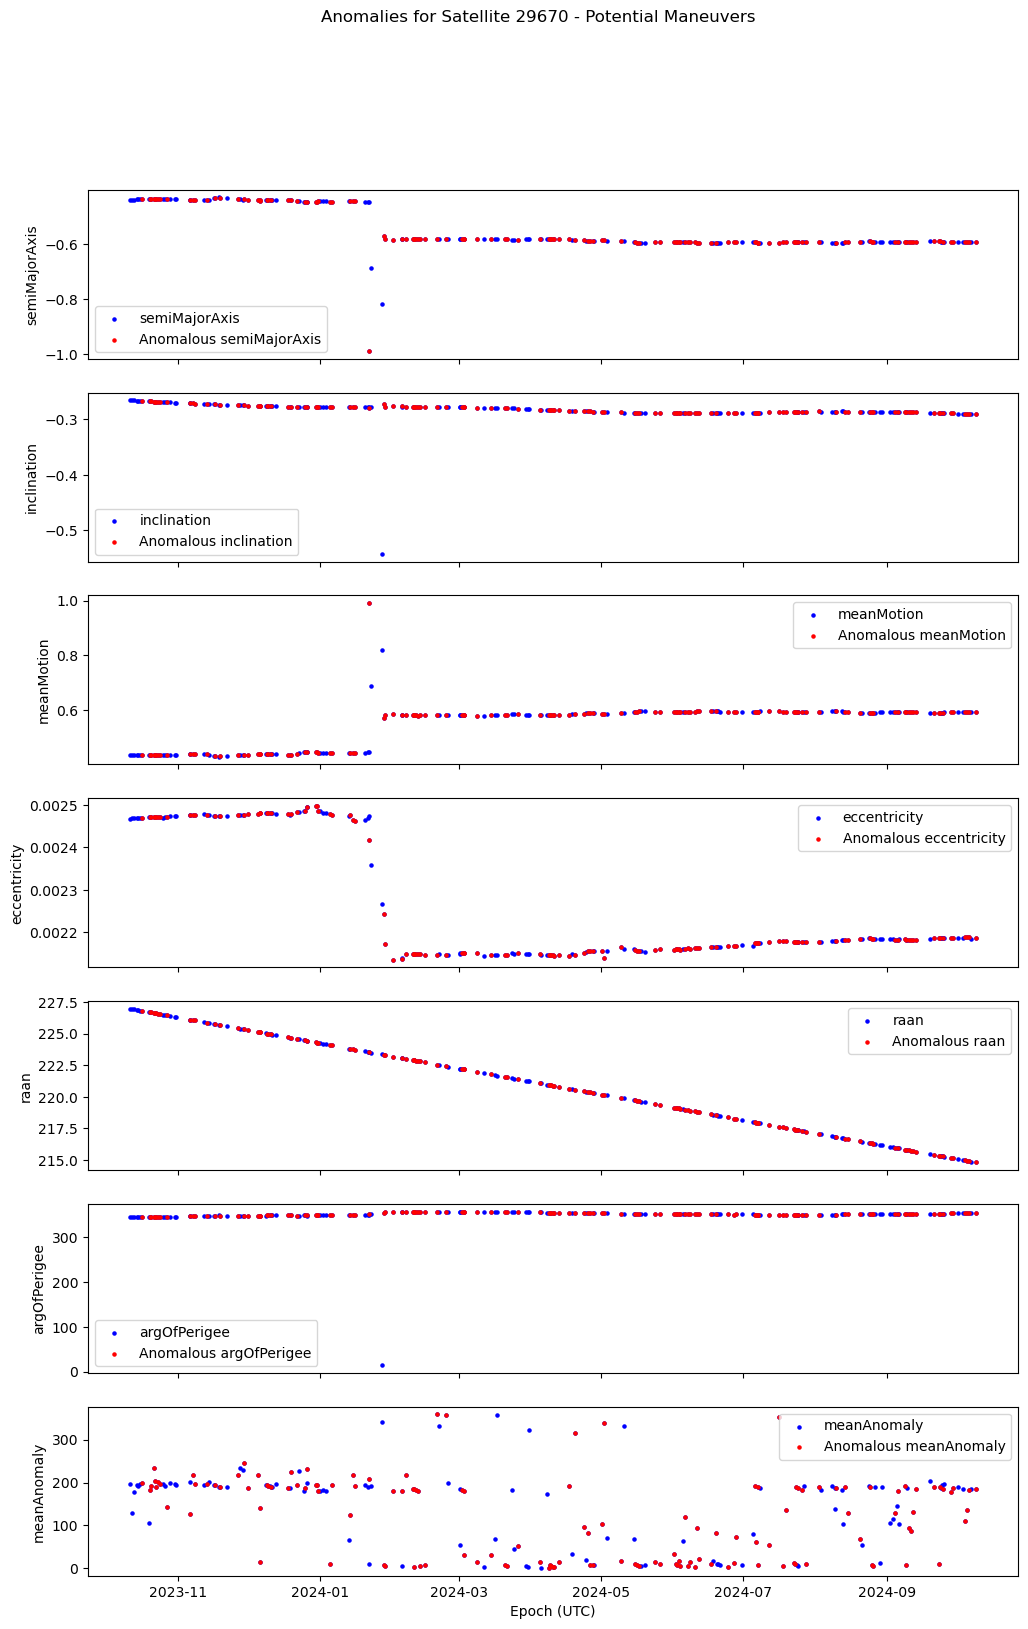

Processing satellite 29671


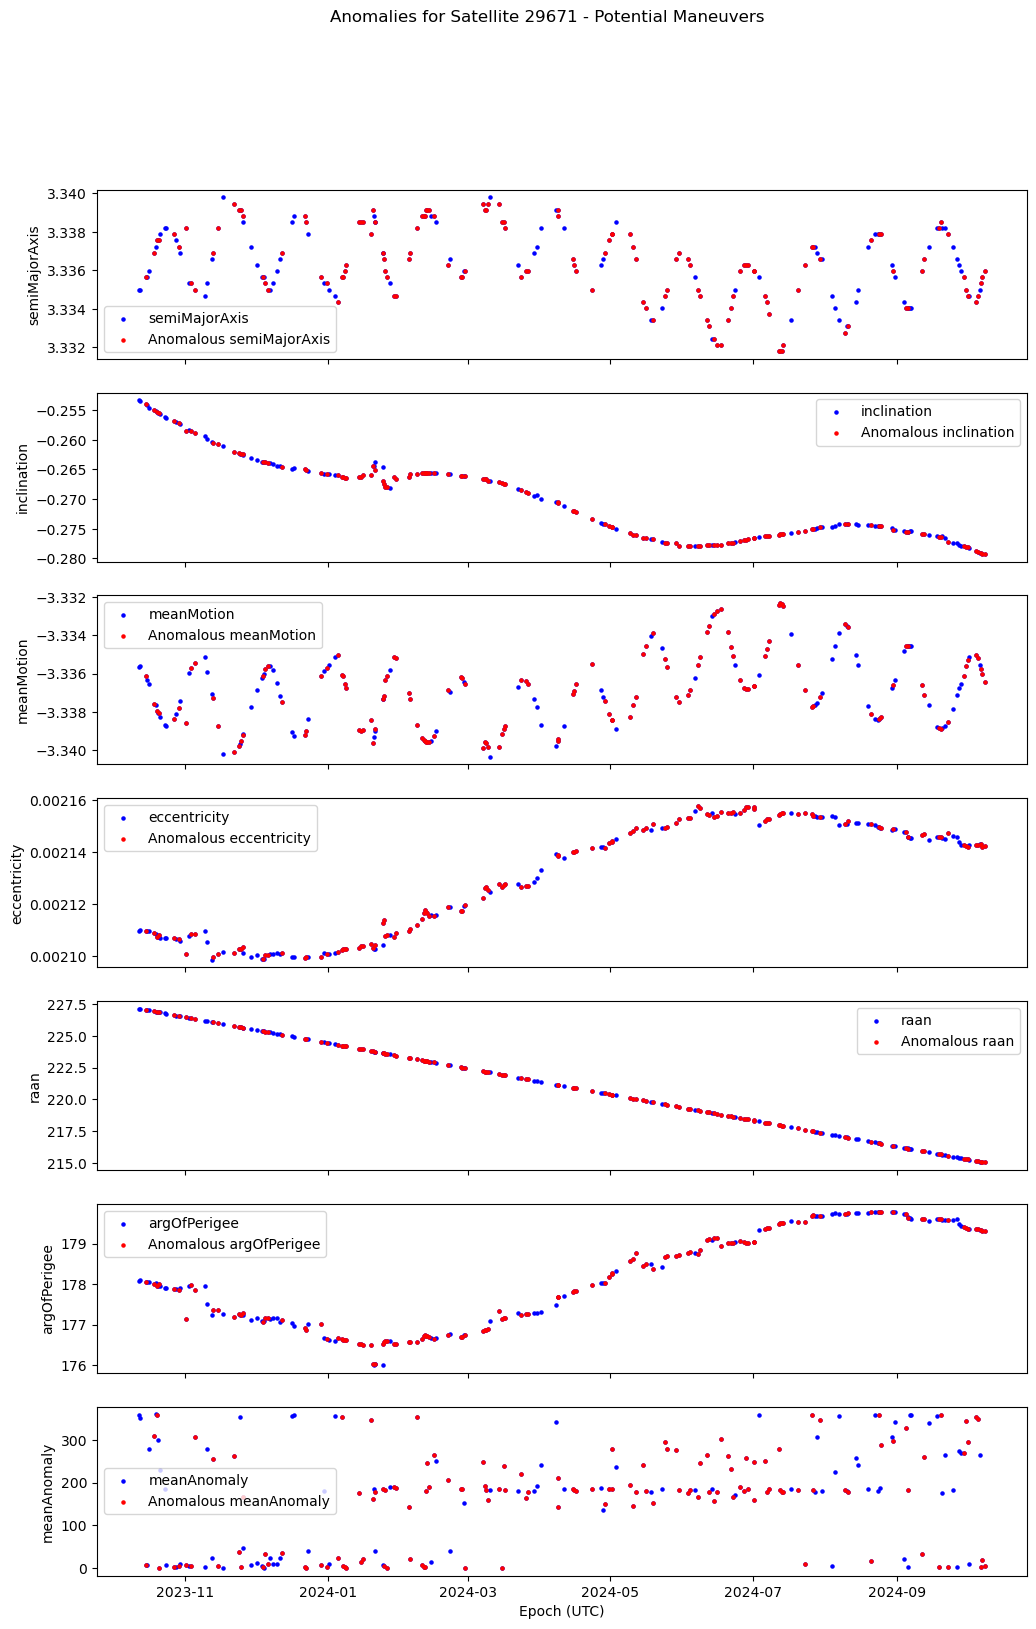

Processing satellite 32275


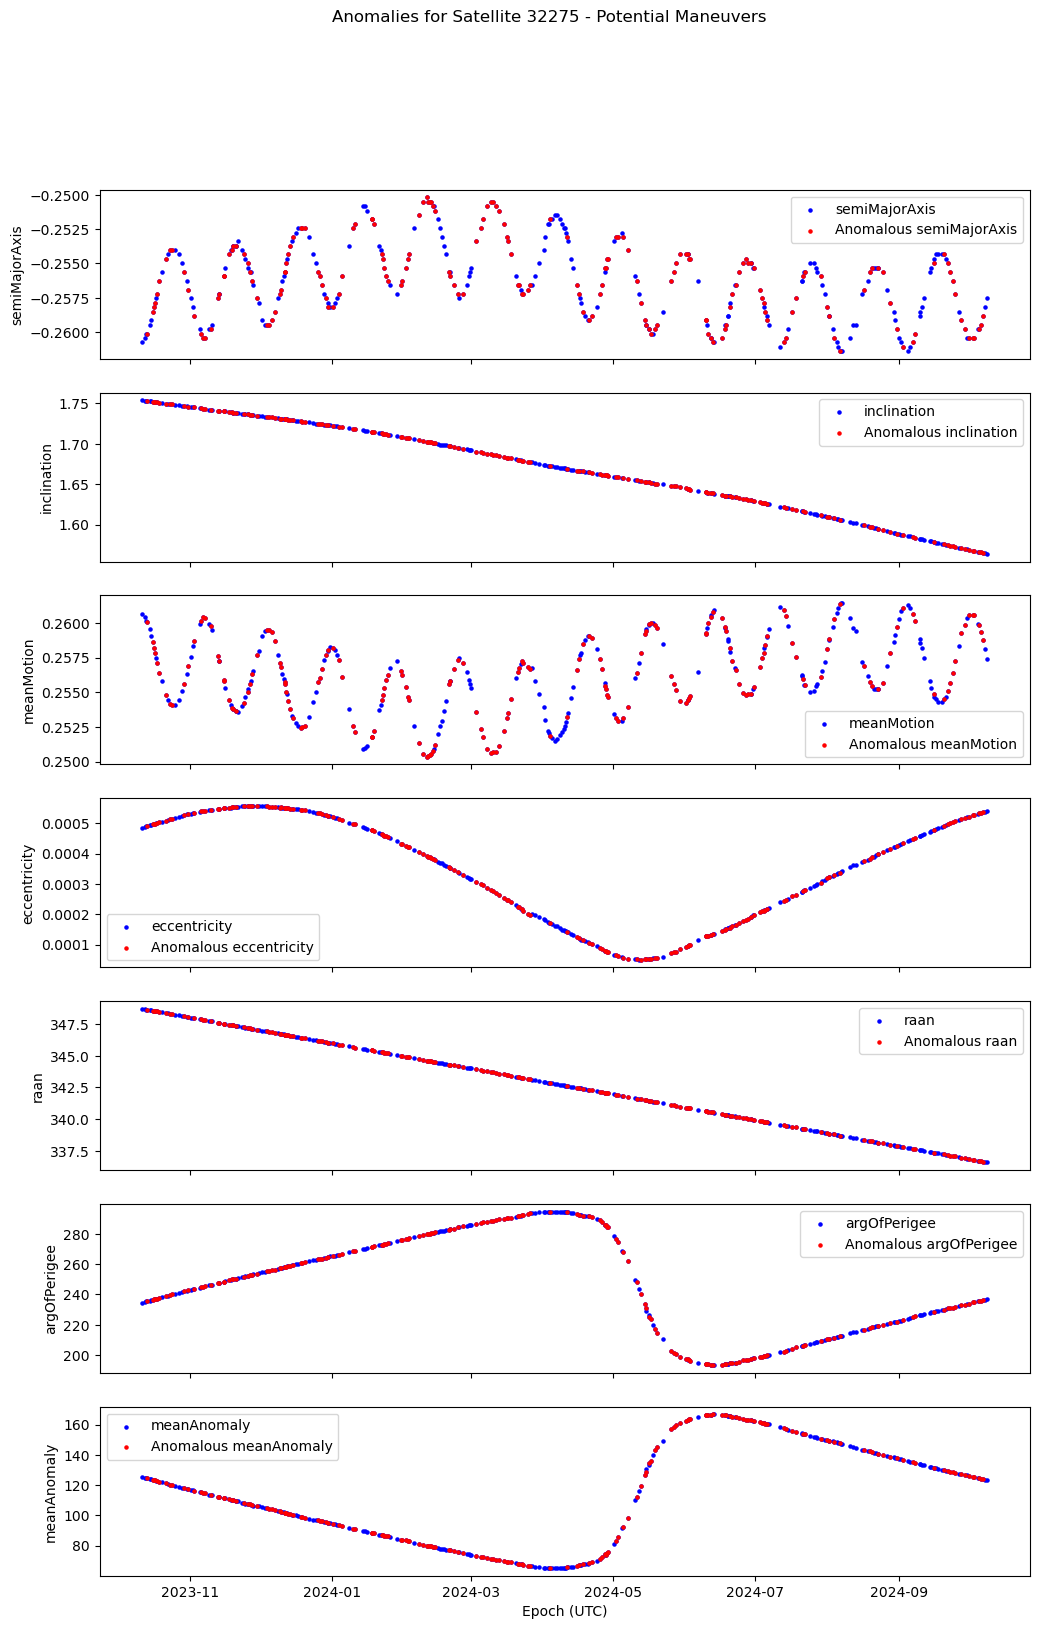

Processing satellite 32276


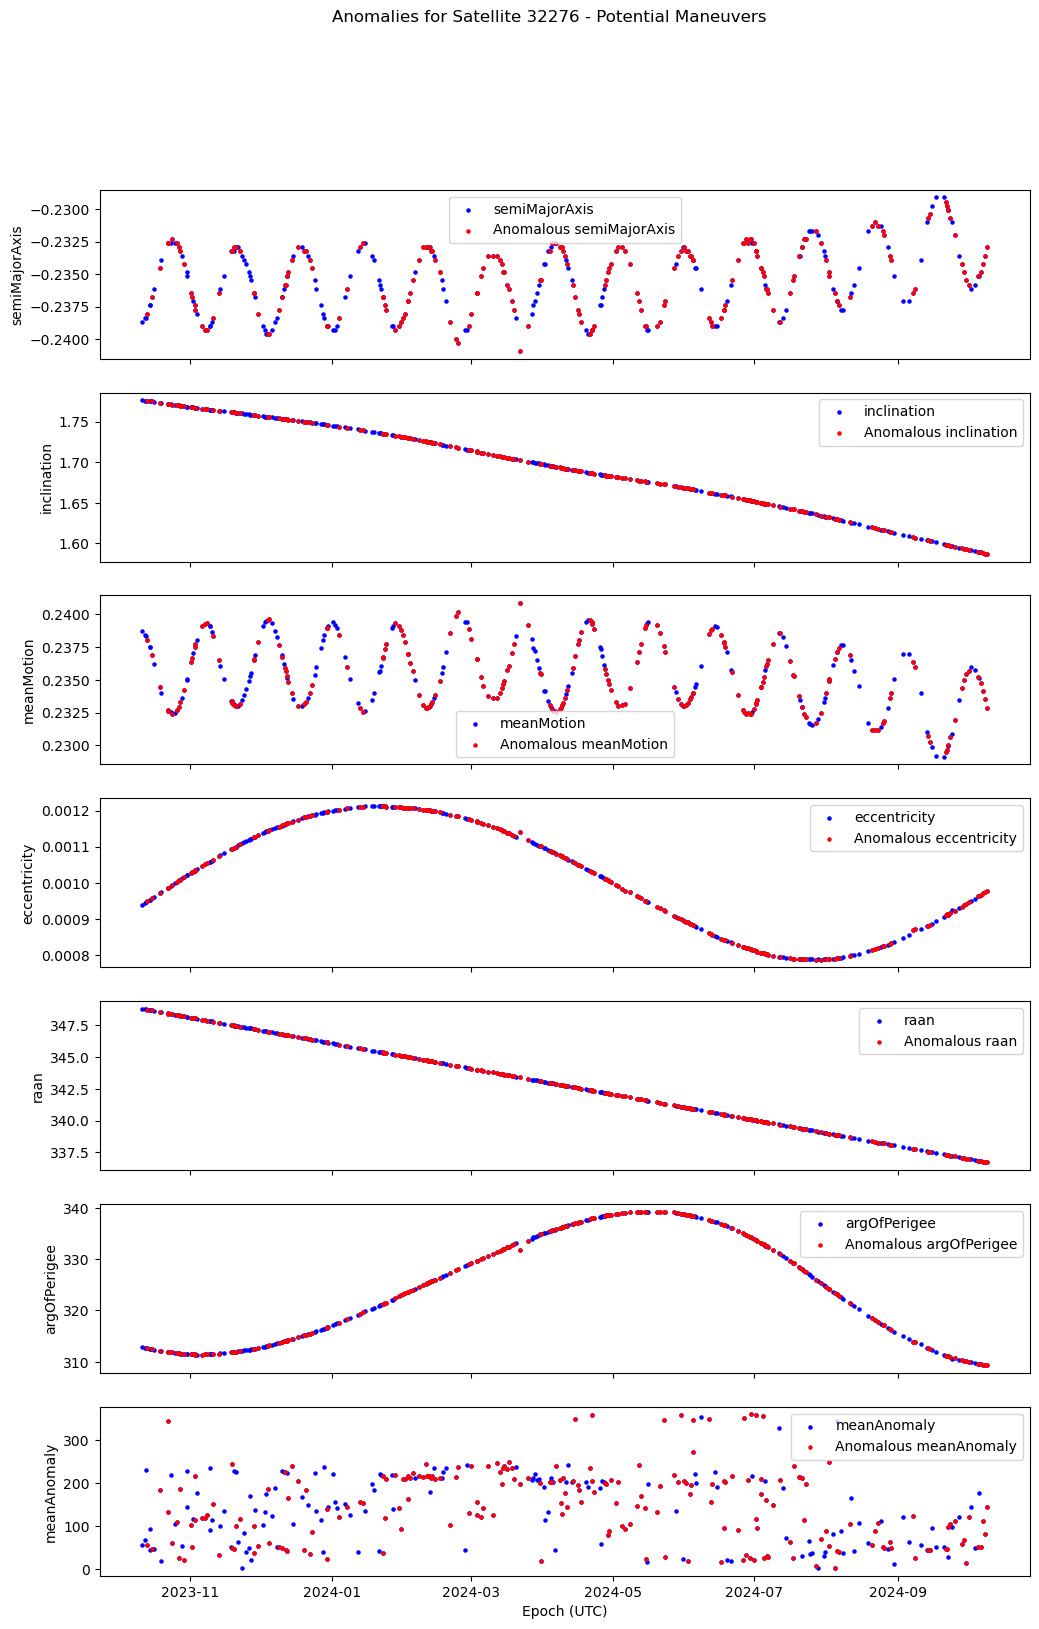

Processing satellite 32393


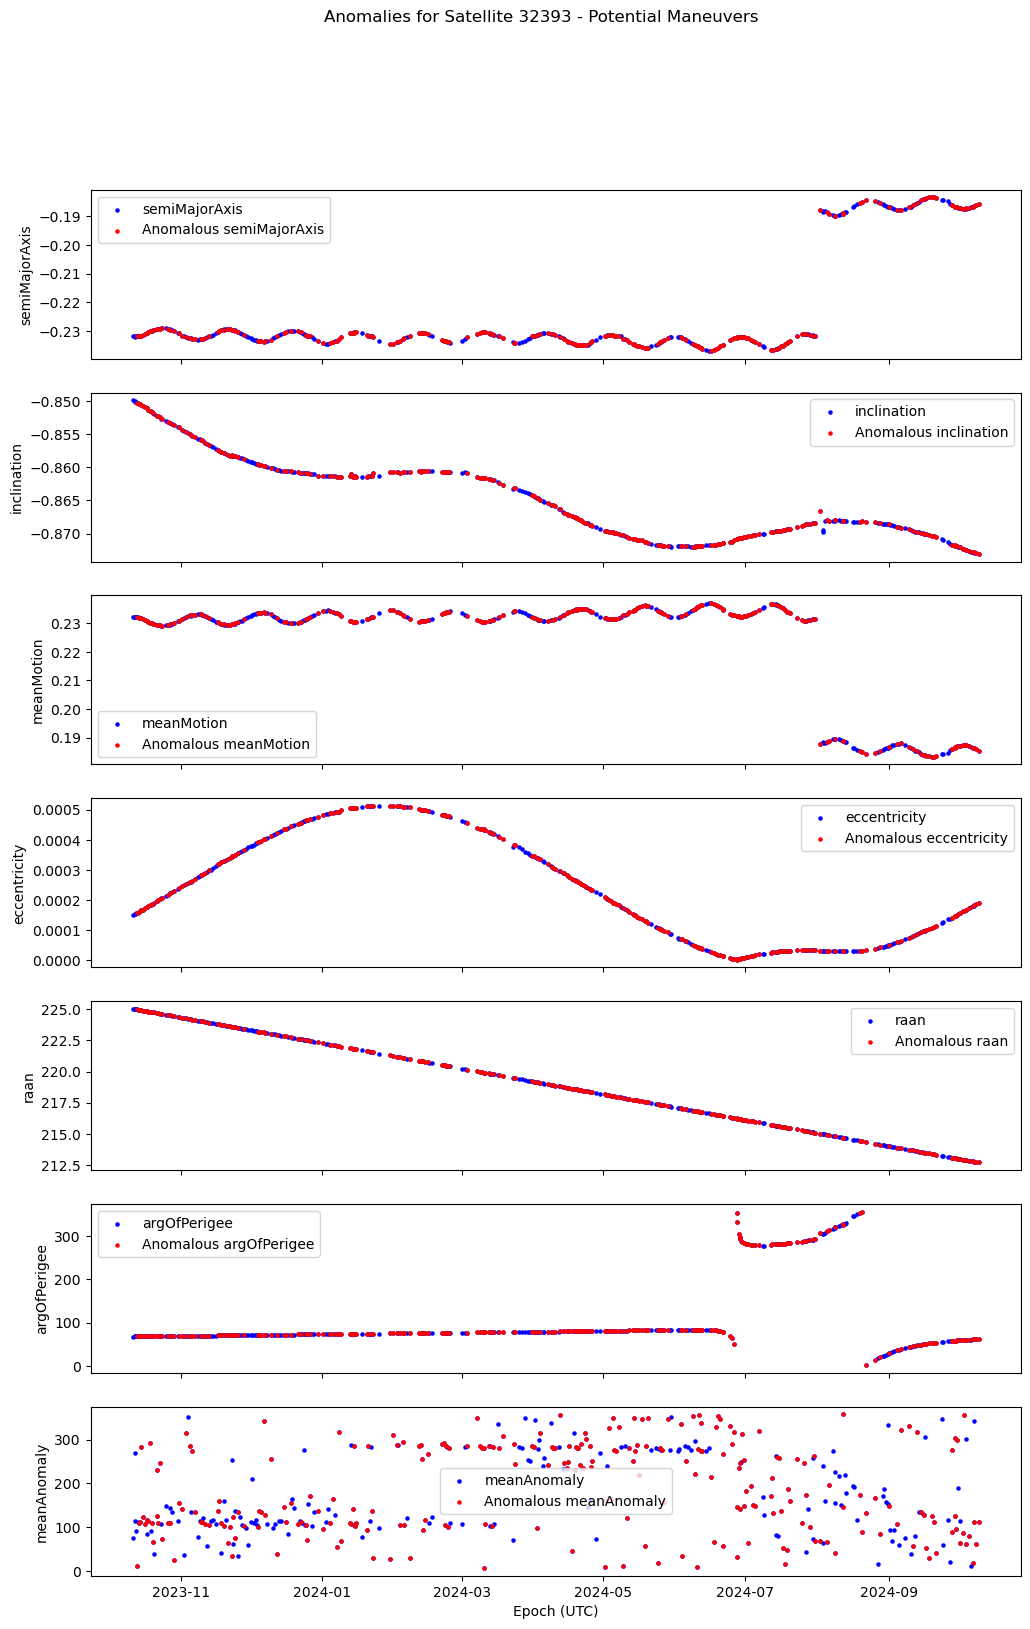

Processing satellite 32395


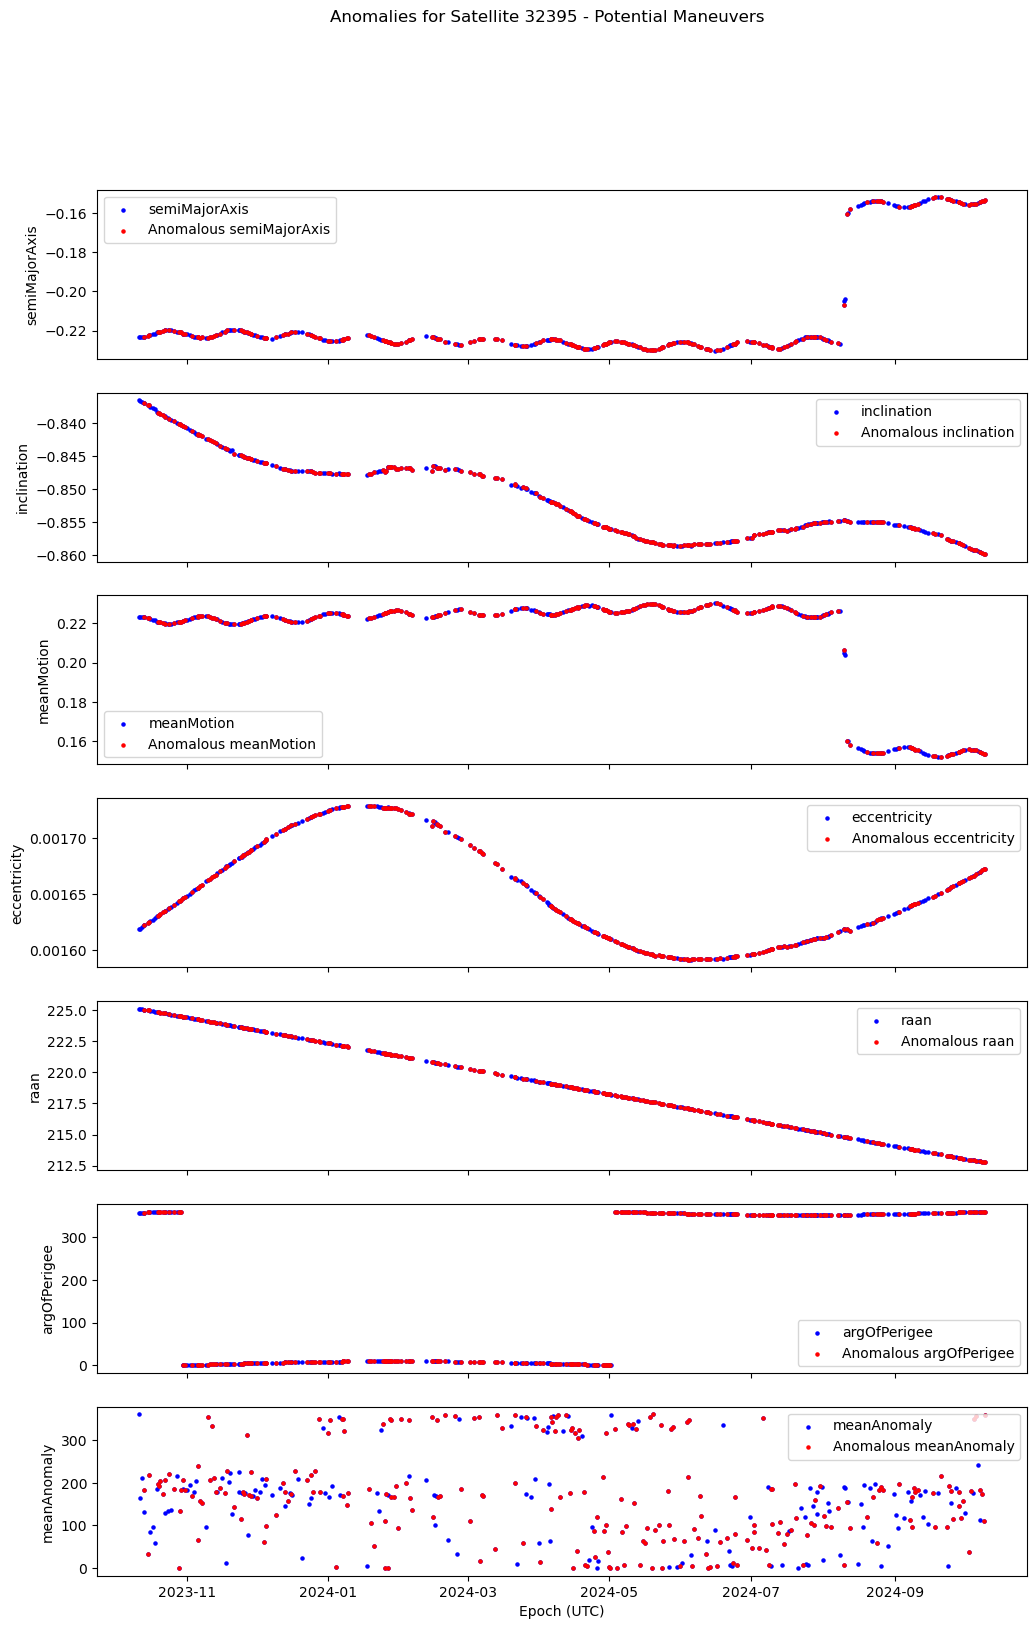

Processing satellite 36111


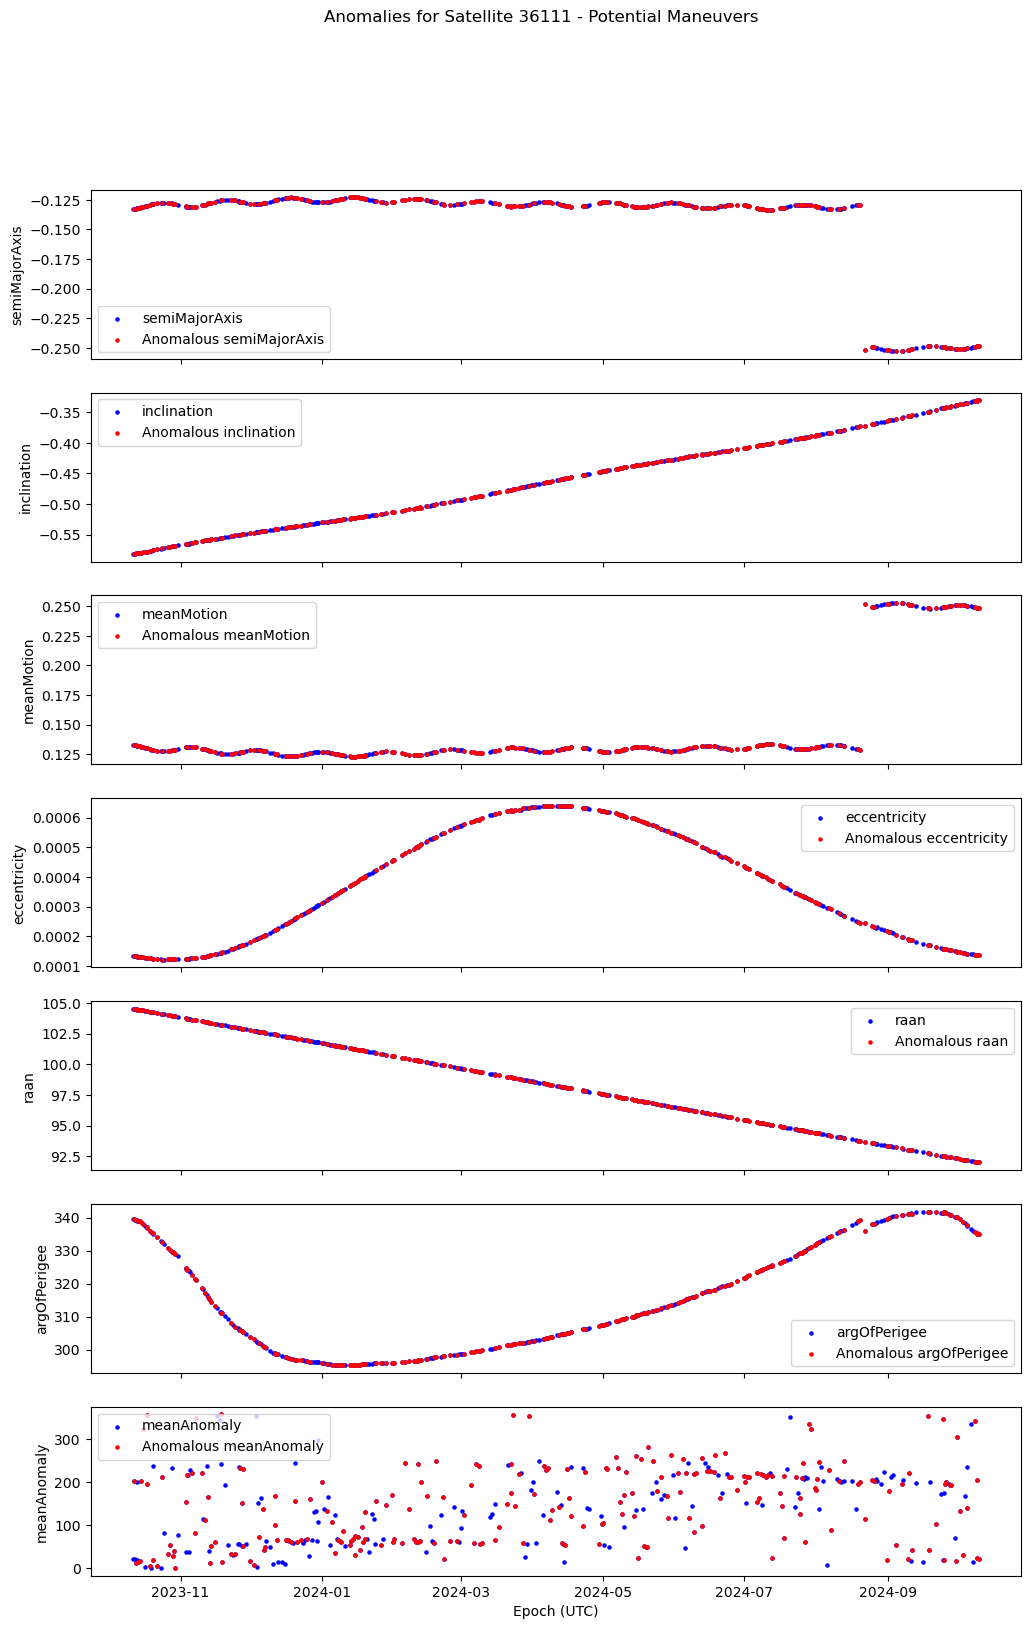

Processing satellite 36112


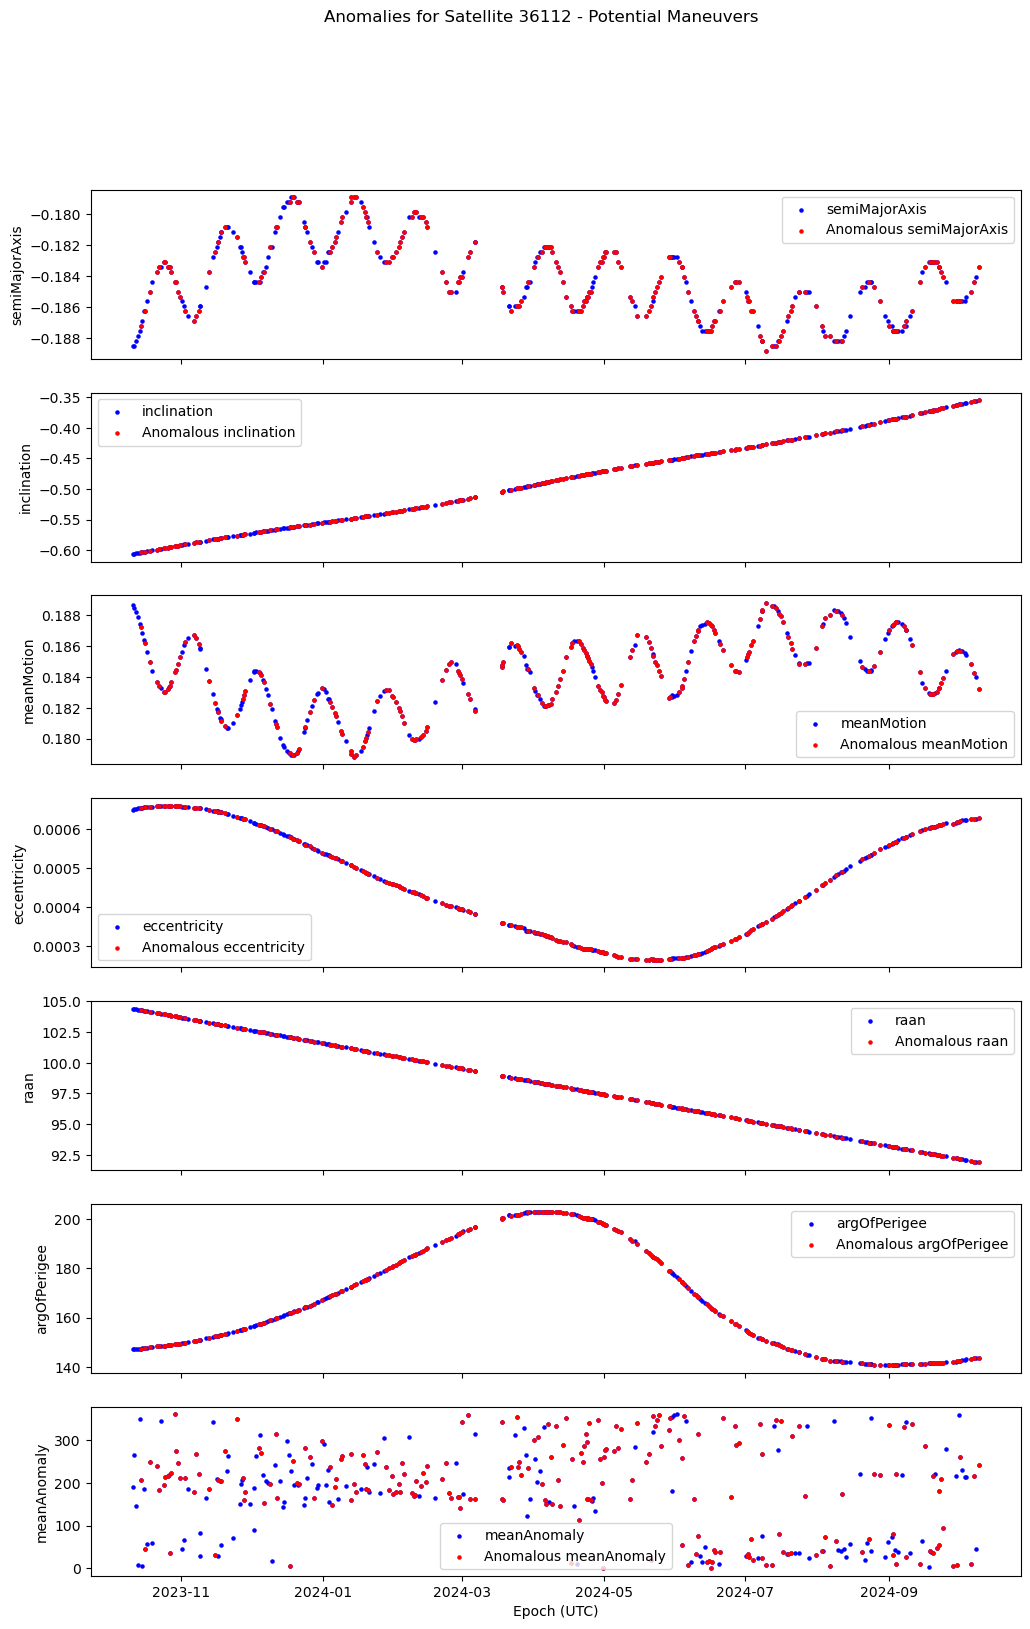

Processing satellite 36400


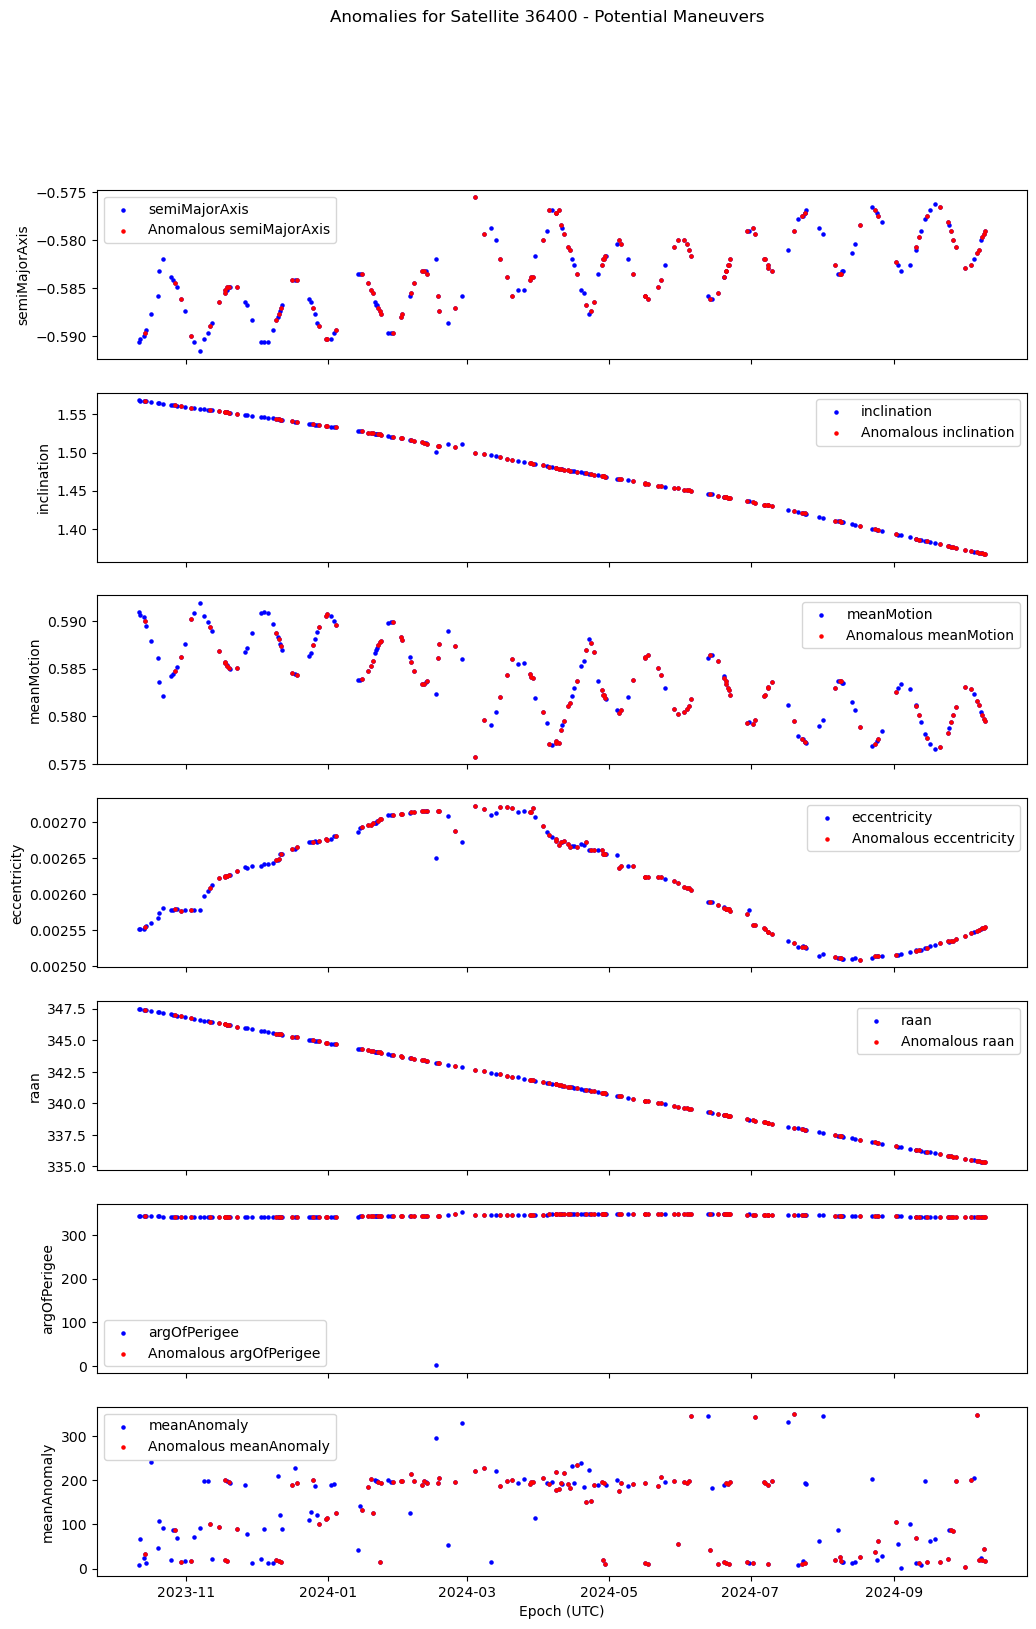

Processing satellite 36401


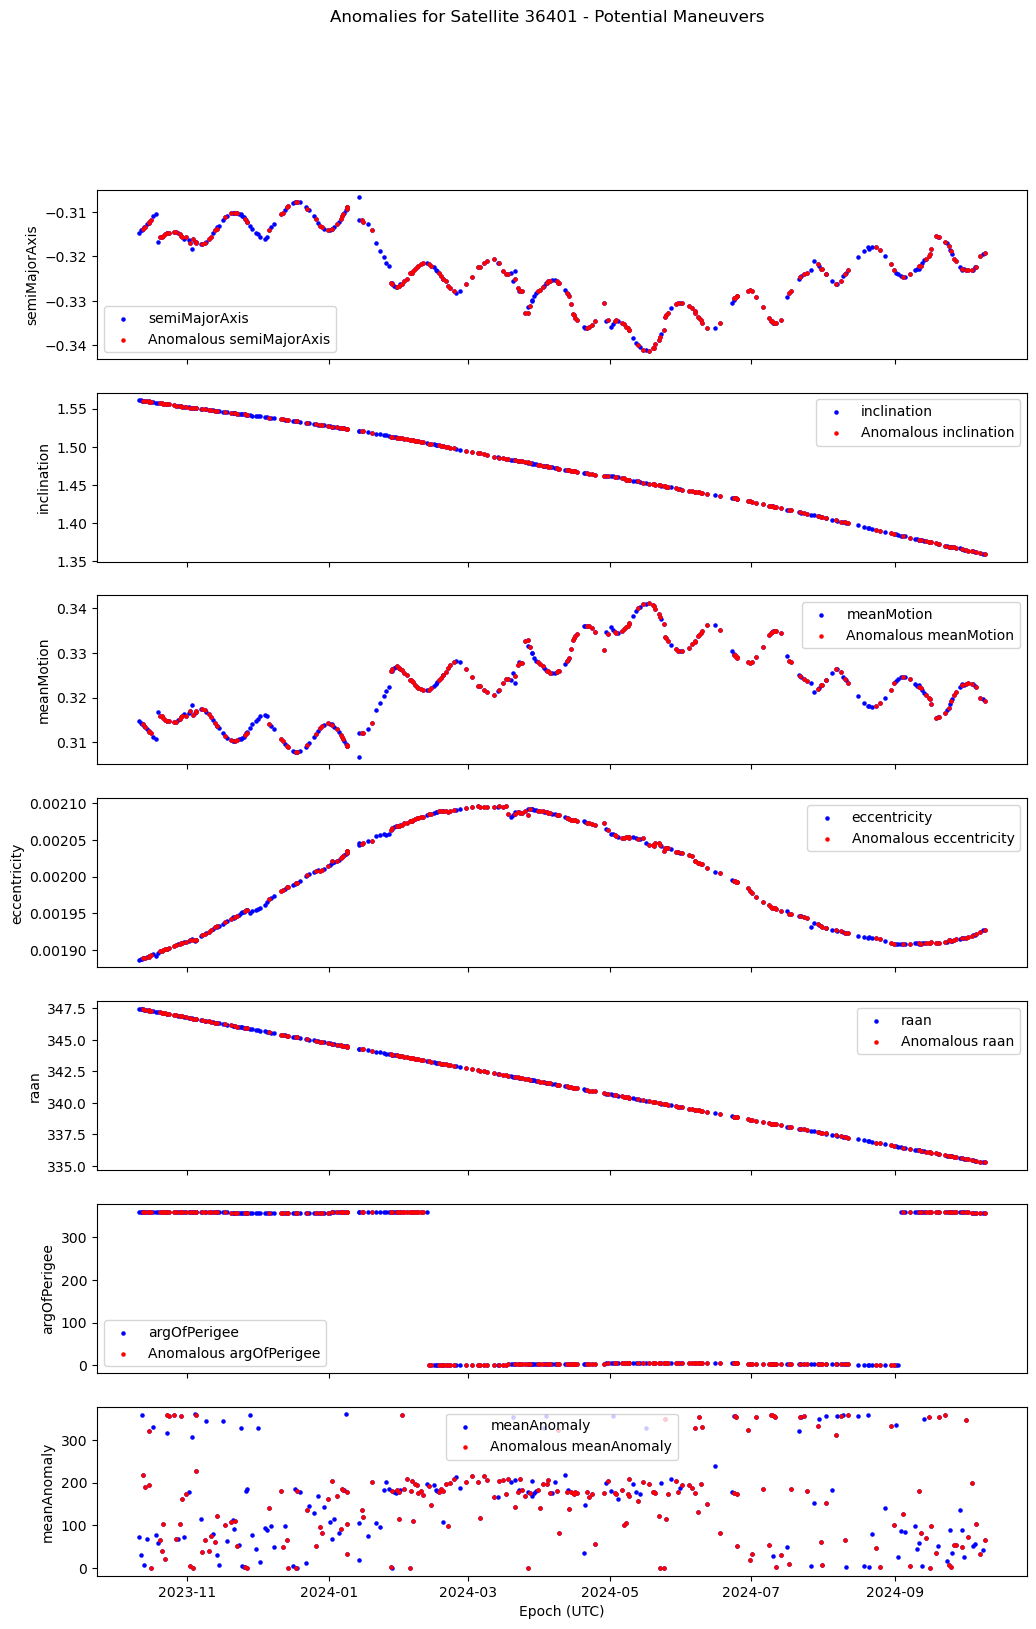

Processing satellite 36402


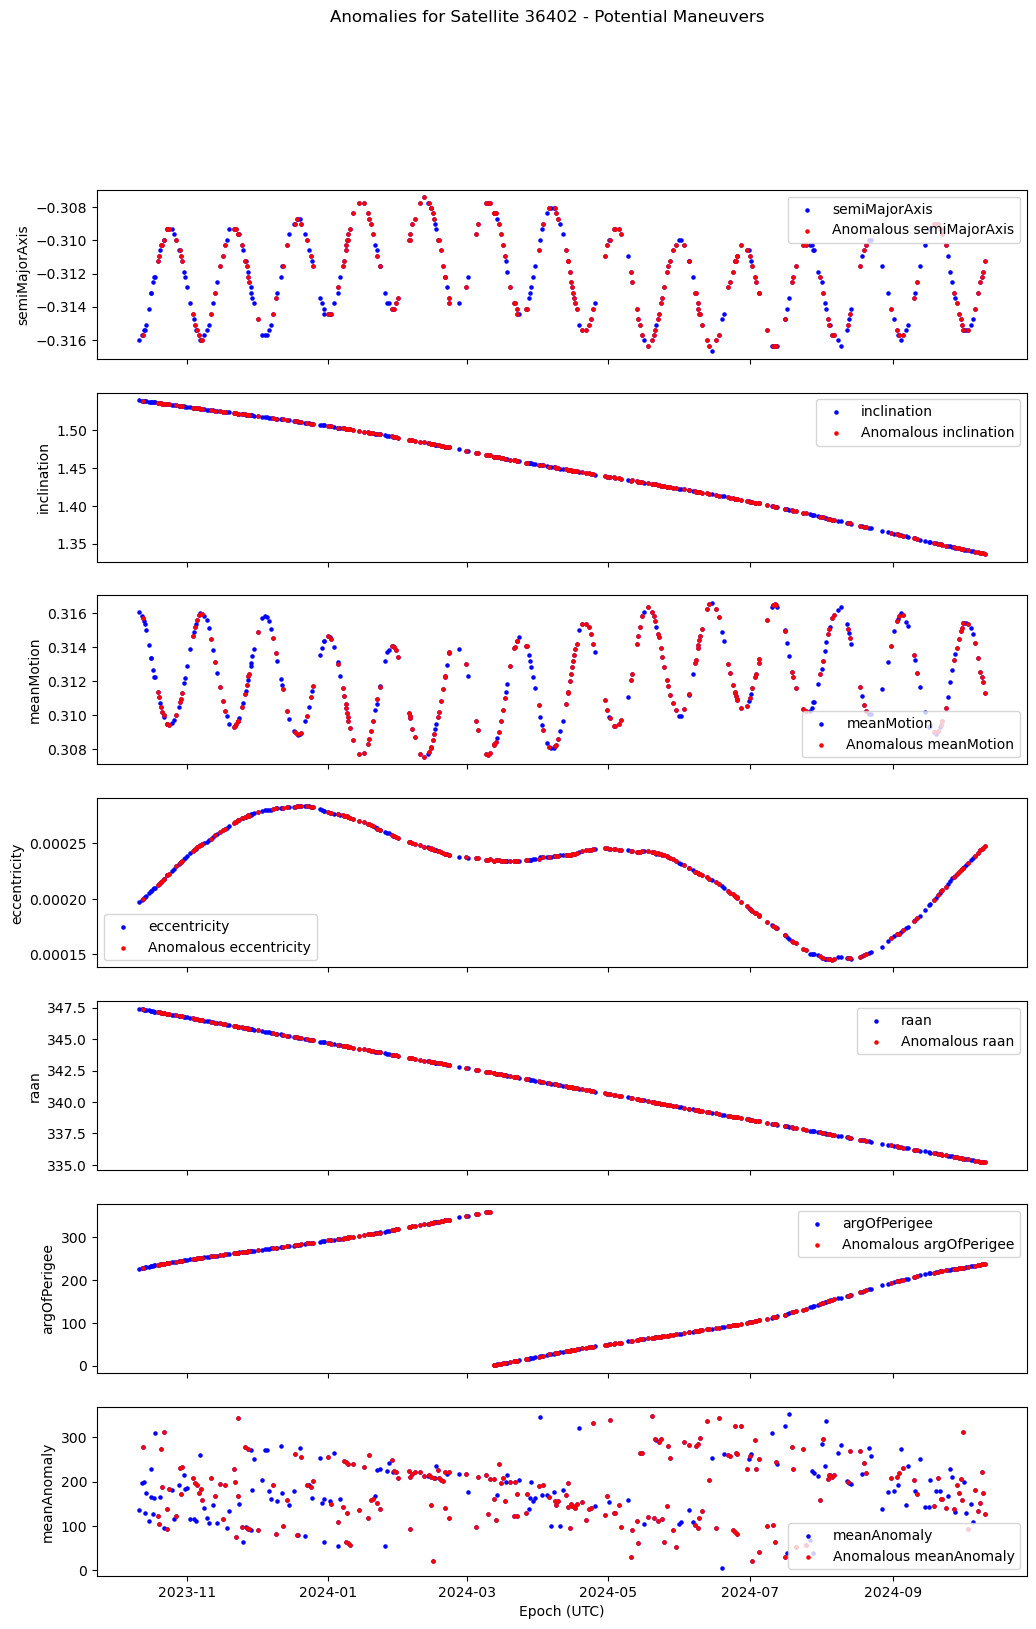

Processing satellite 37139


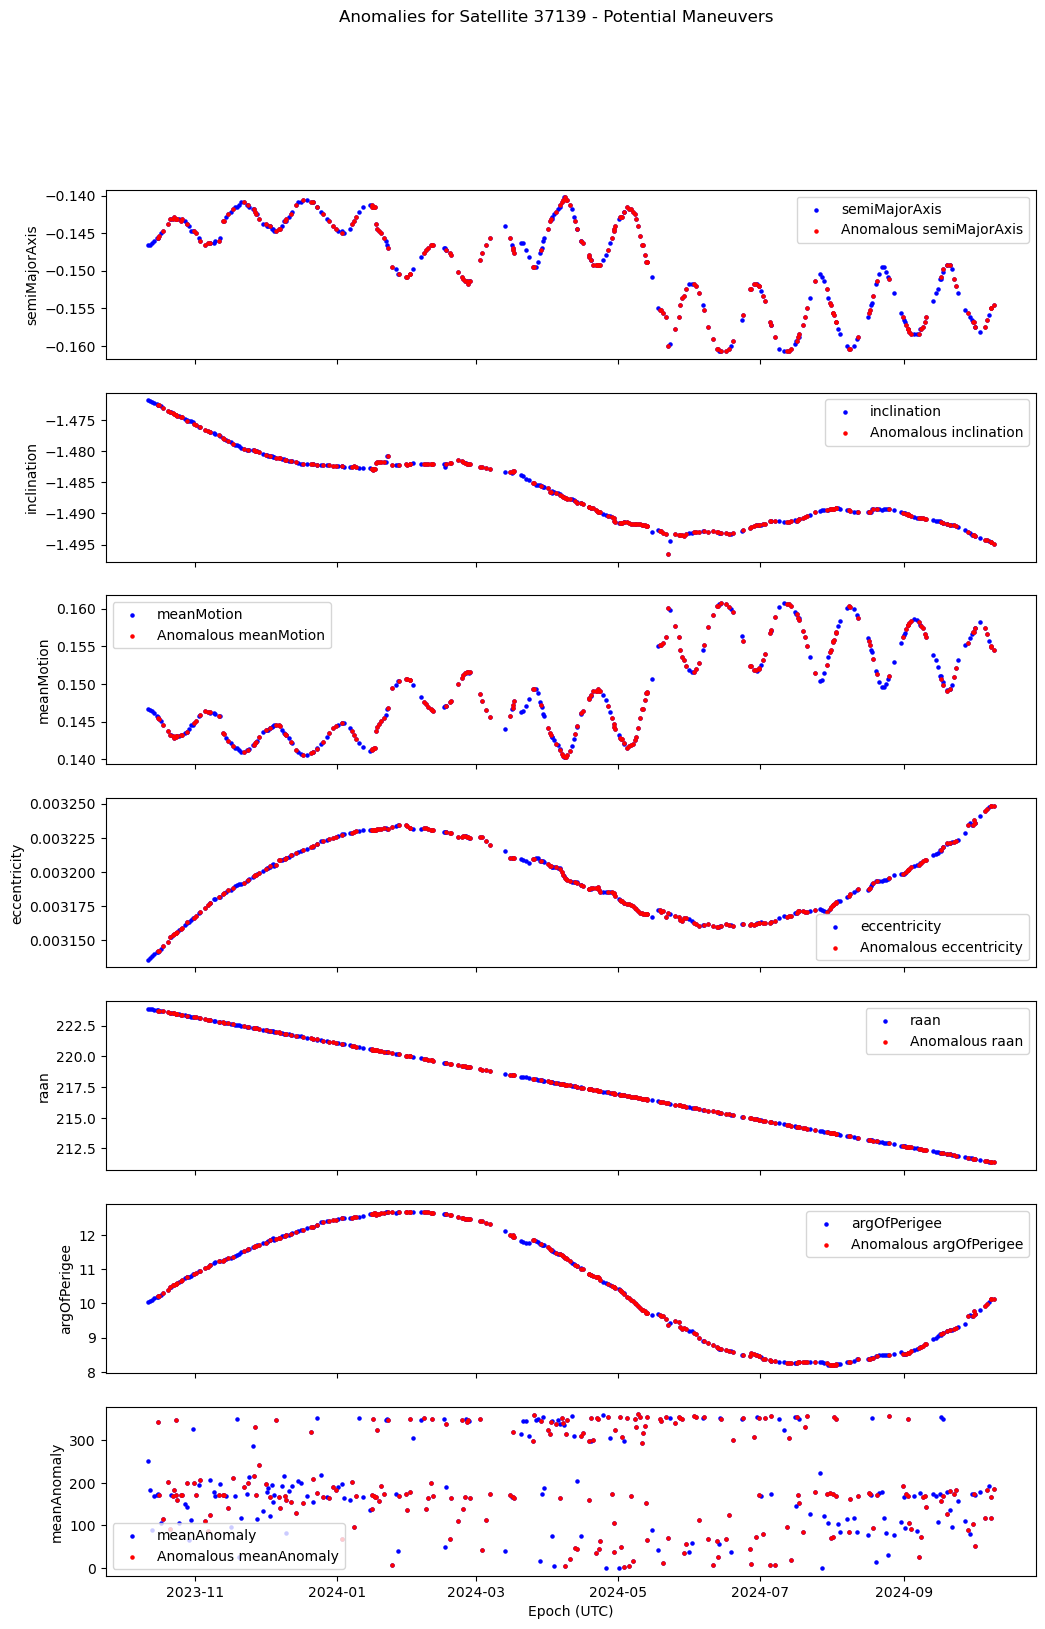

Processing satellite 37372


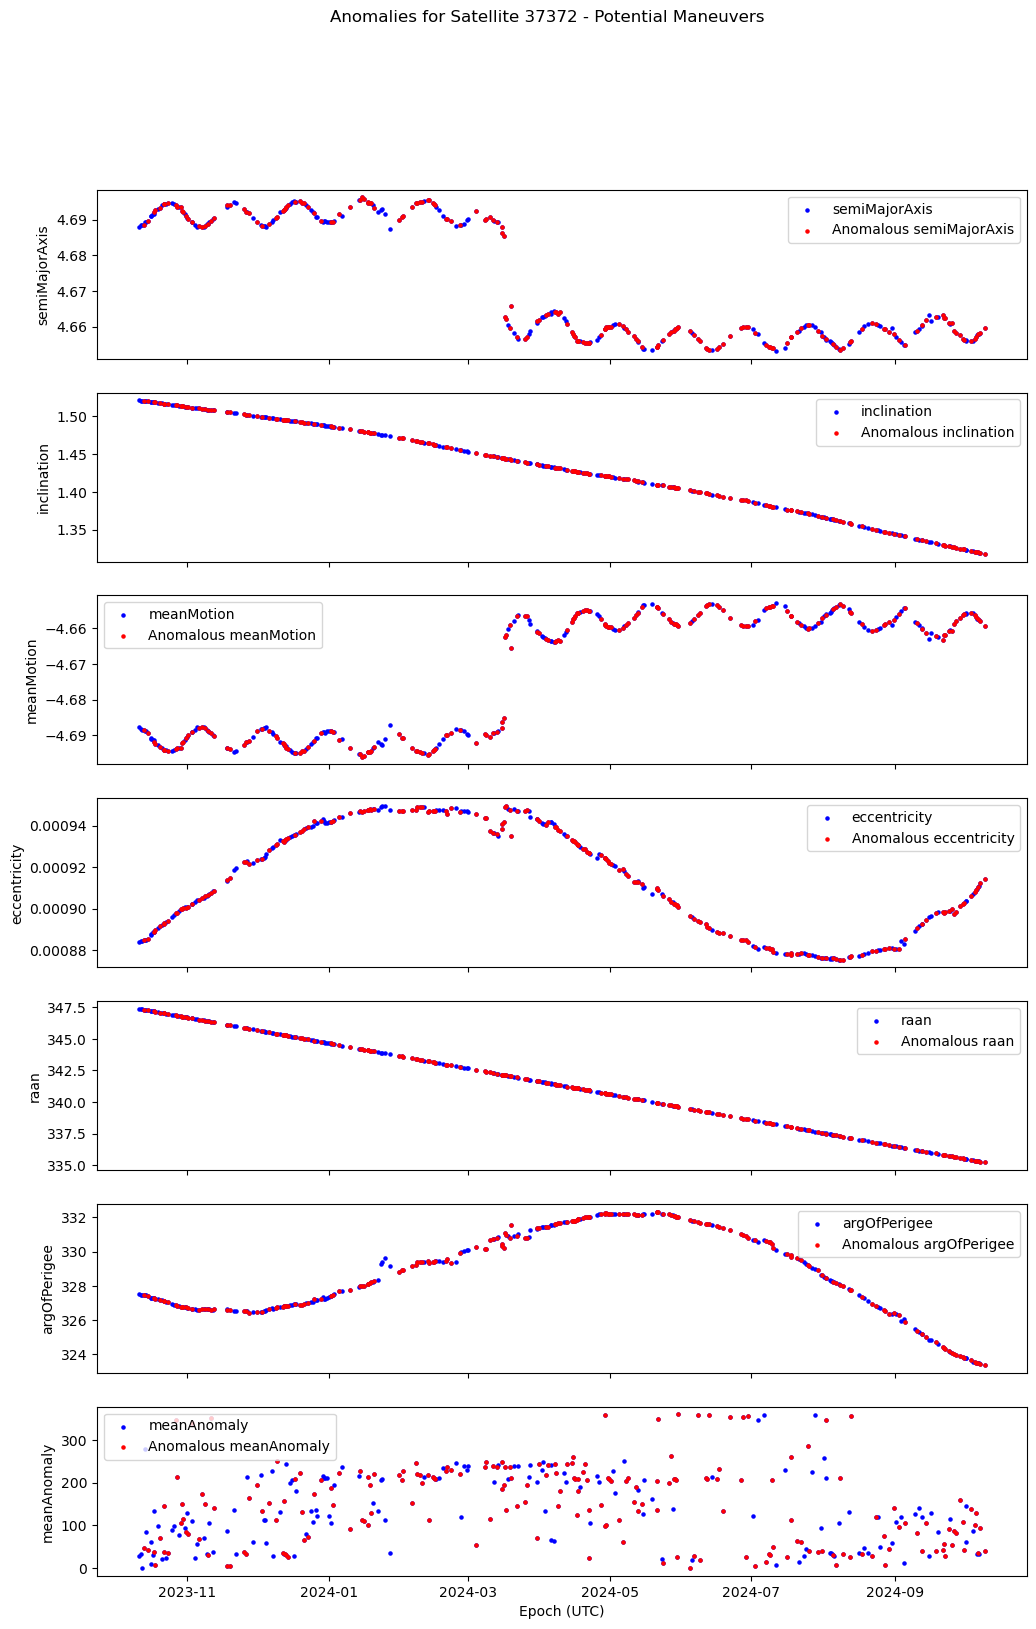

Processing satellite 37867


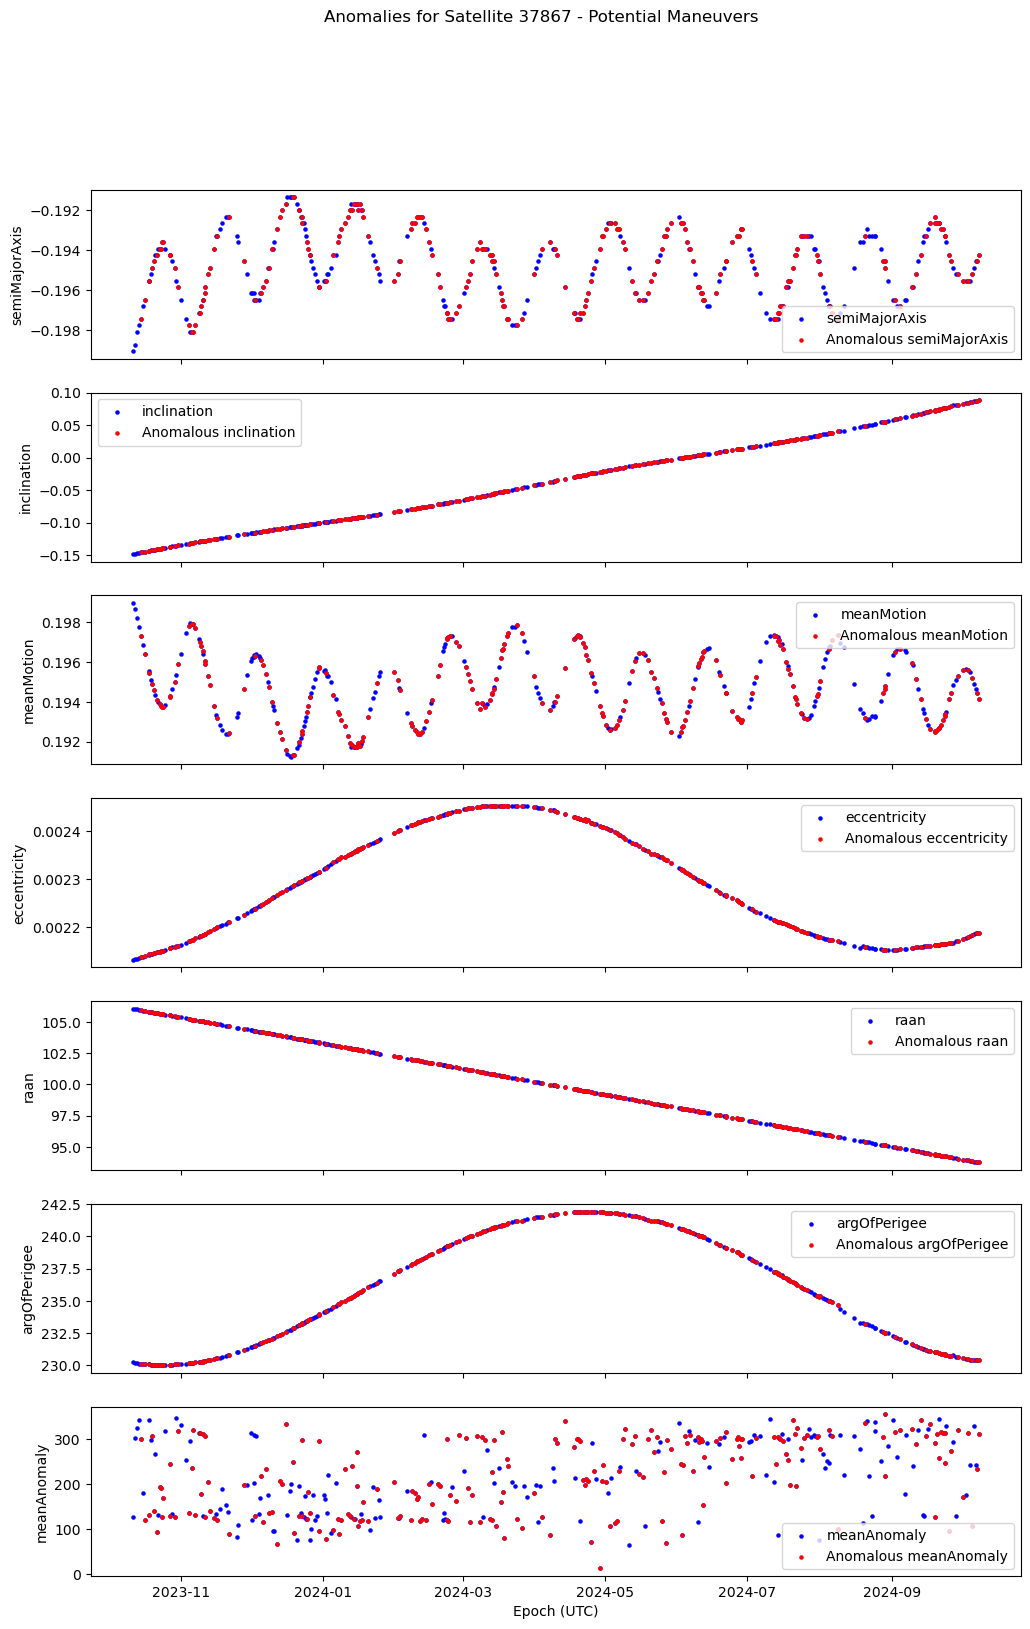

Processing satellite 37868


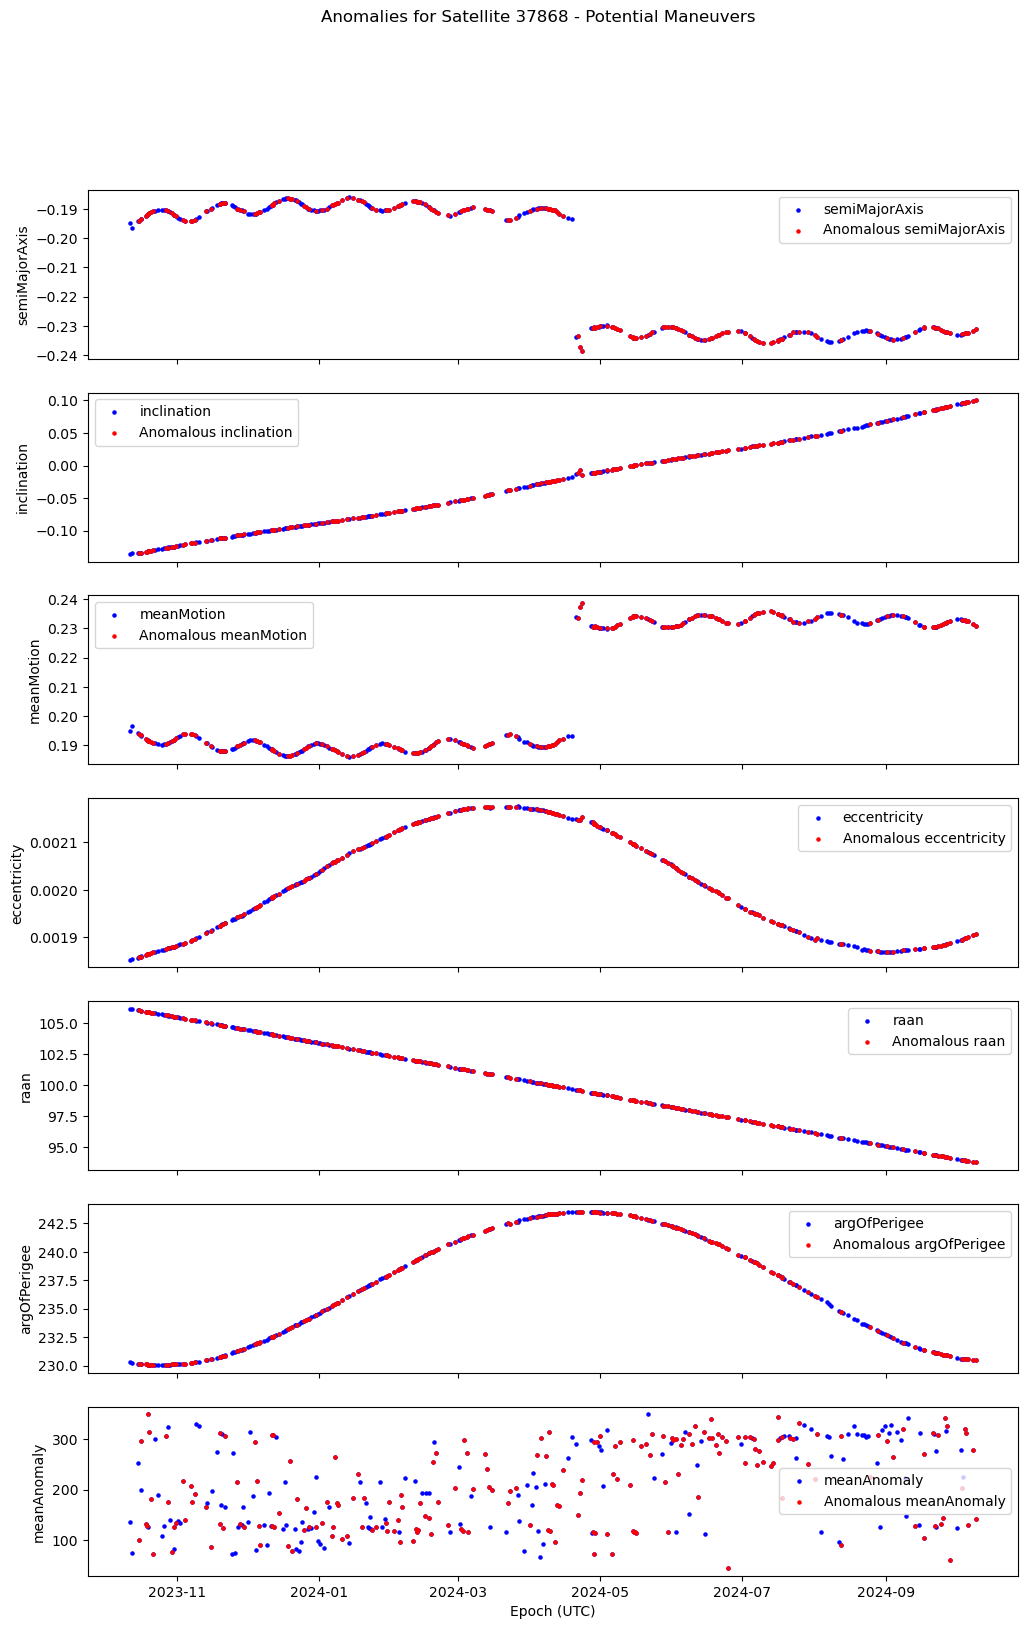

Processing satellite 37869


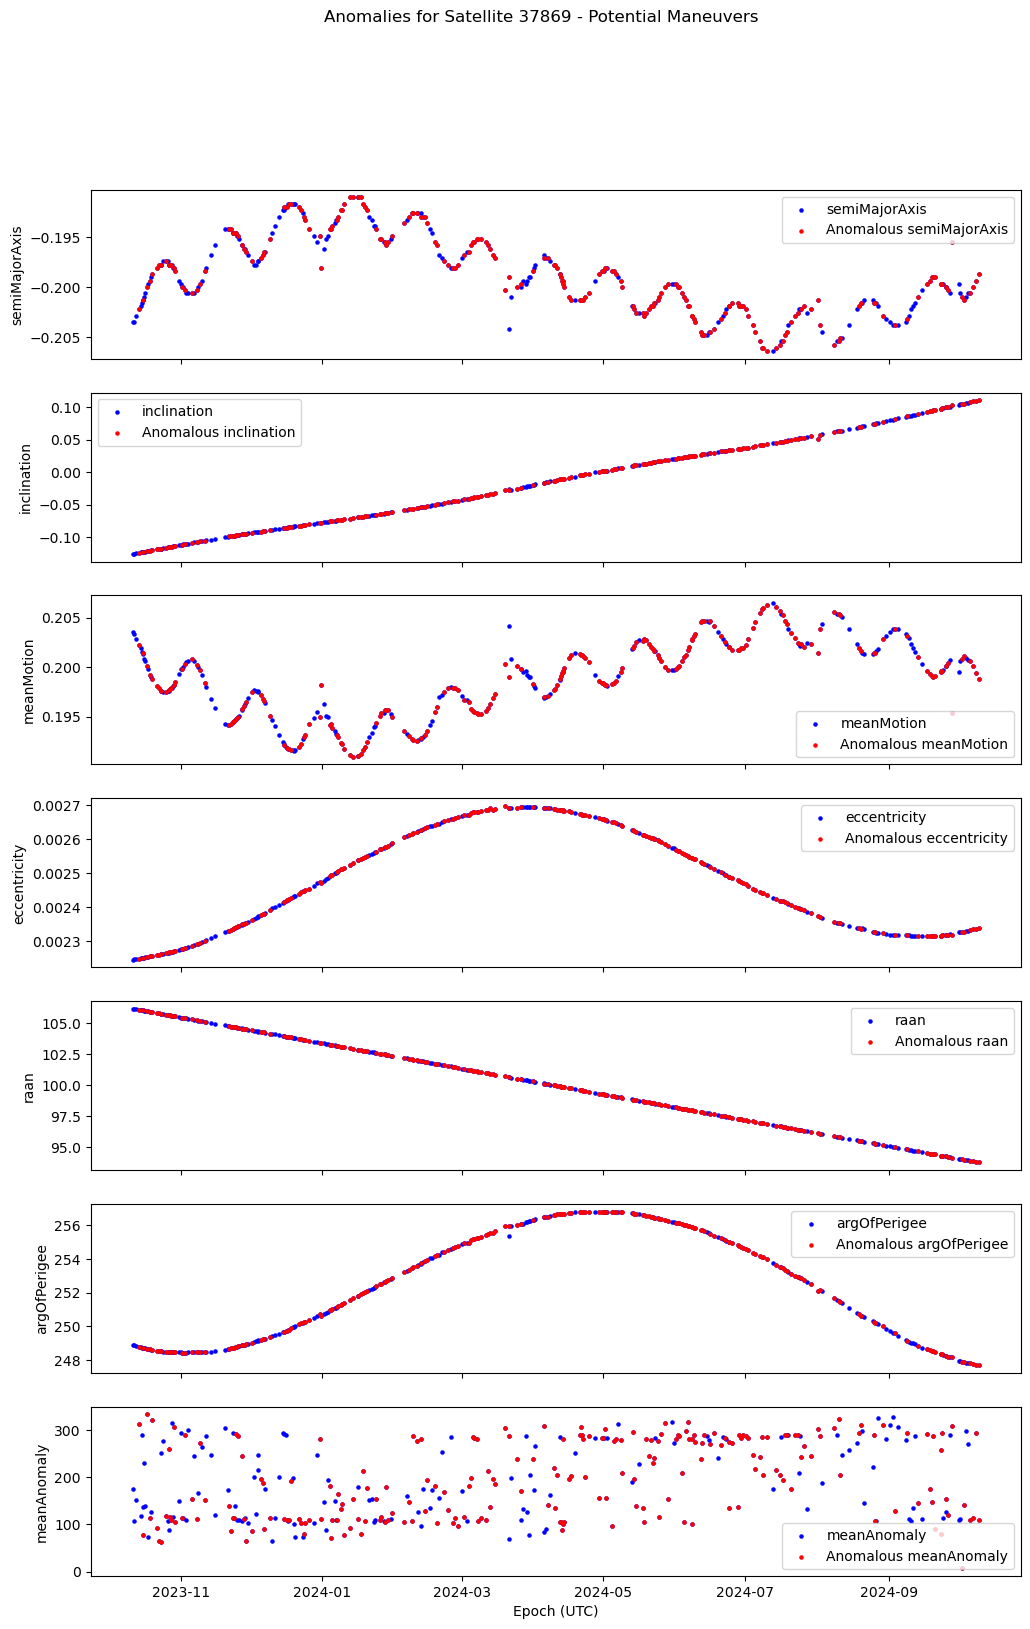

Processing satellite 39155


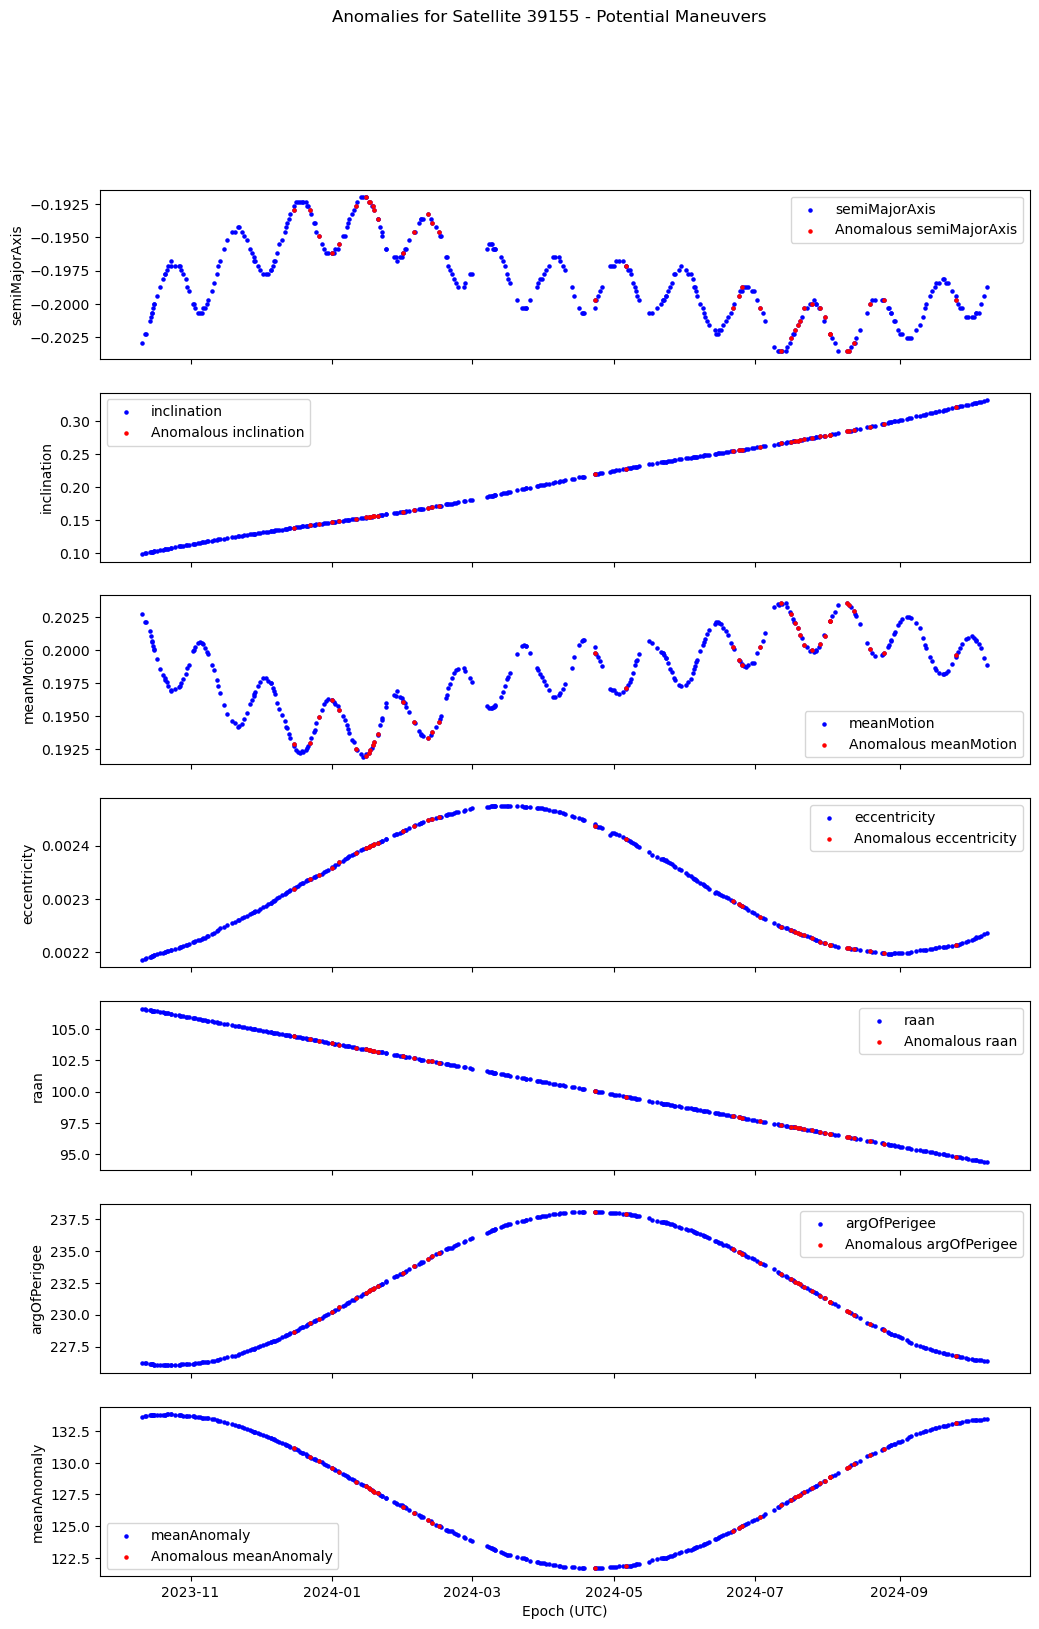

Processing satellite 40001


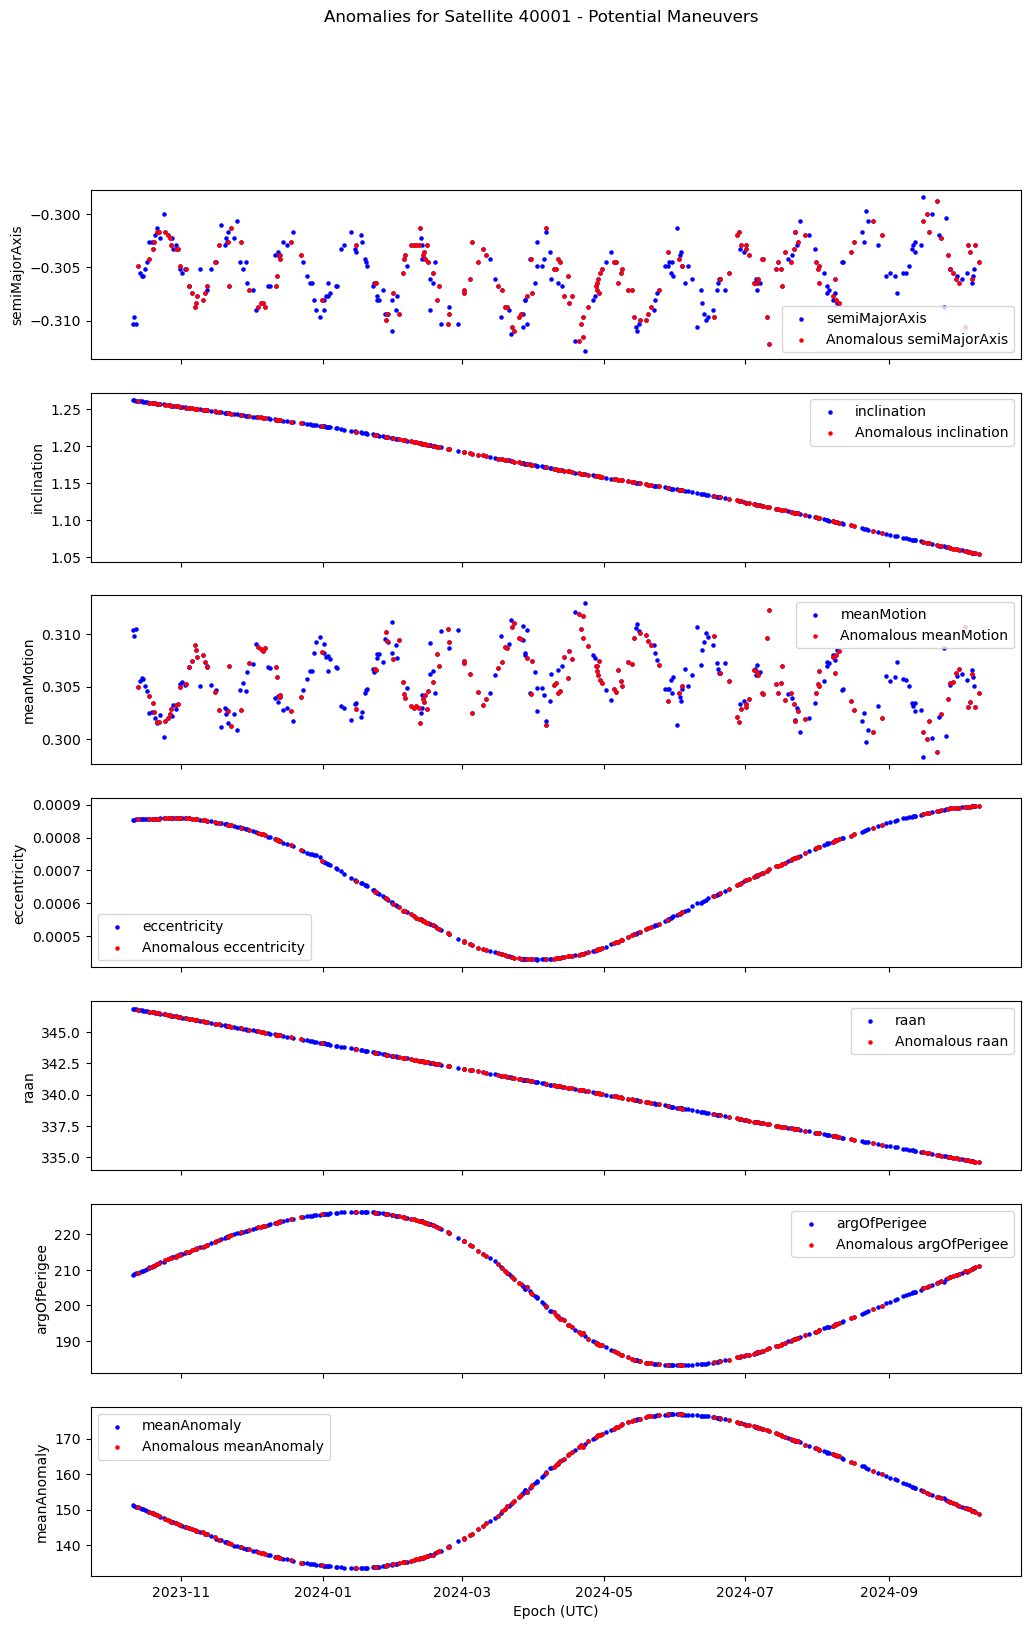

Processing satellite 40315


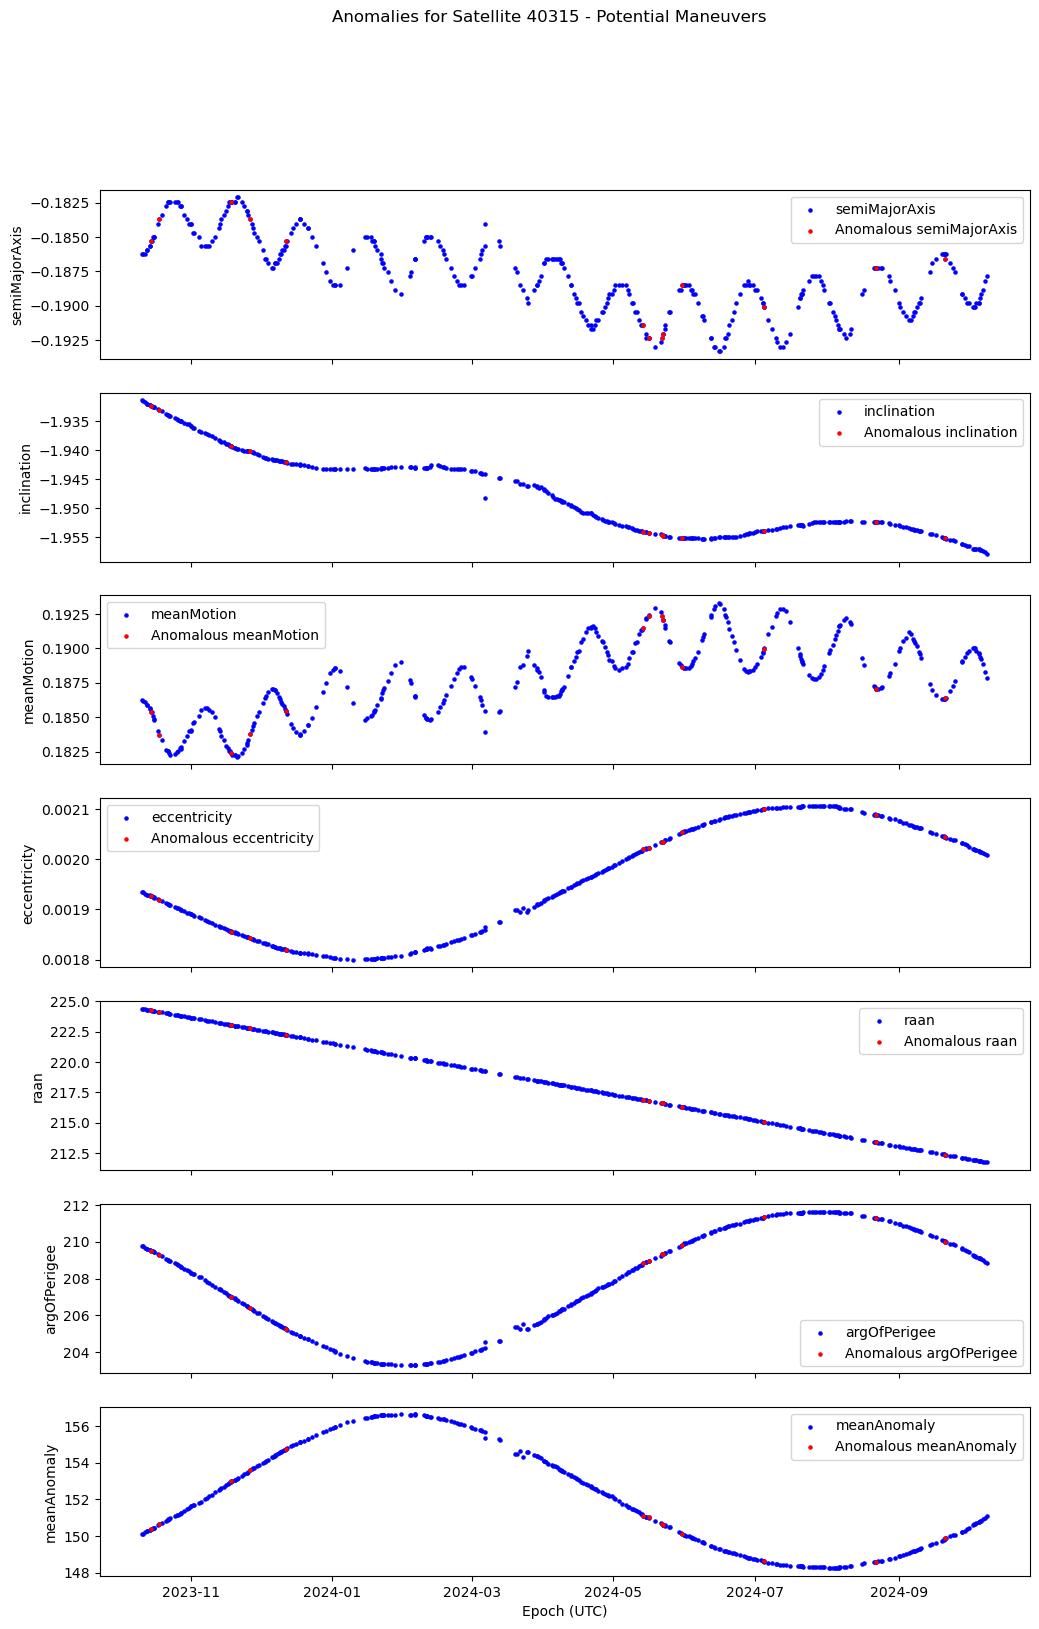

Processing satellite 41330


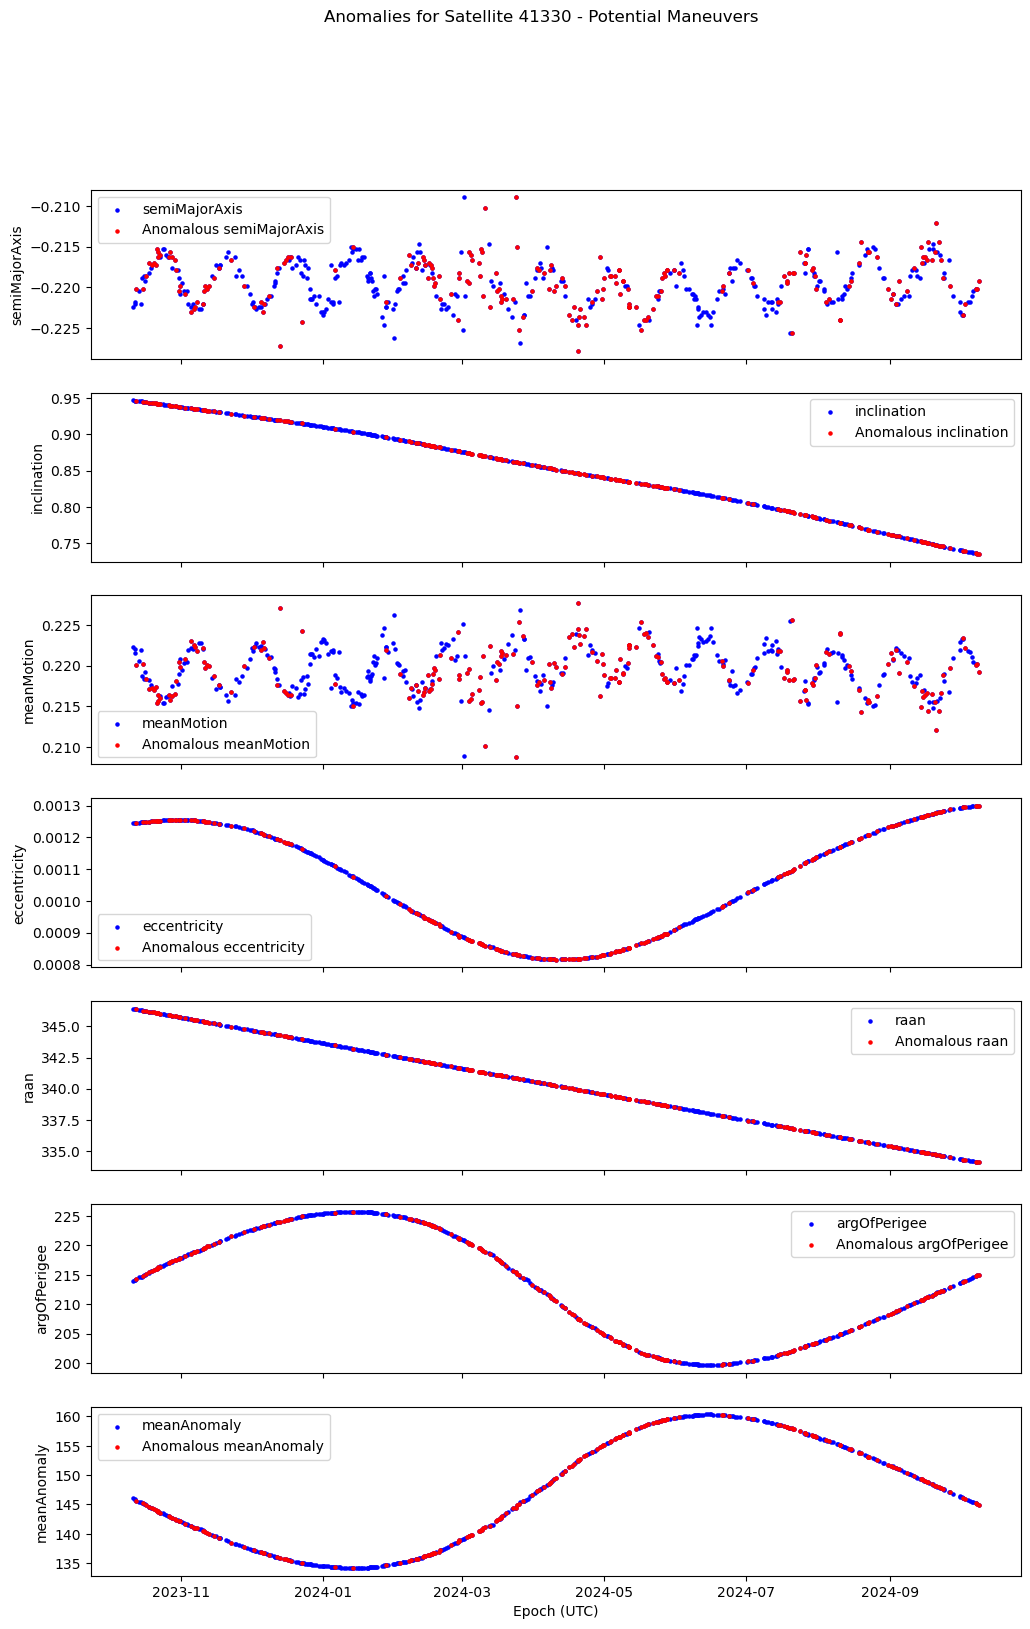

Processing satellite 41554


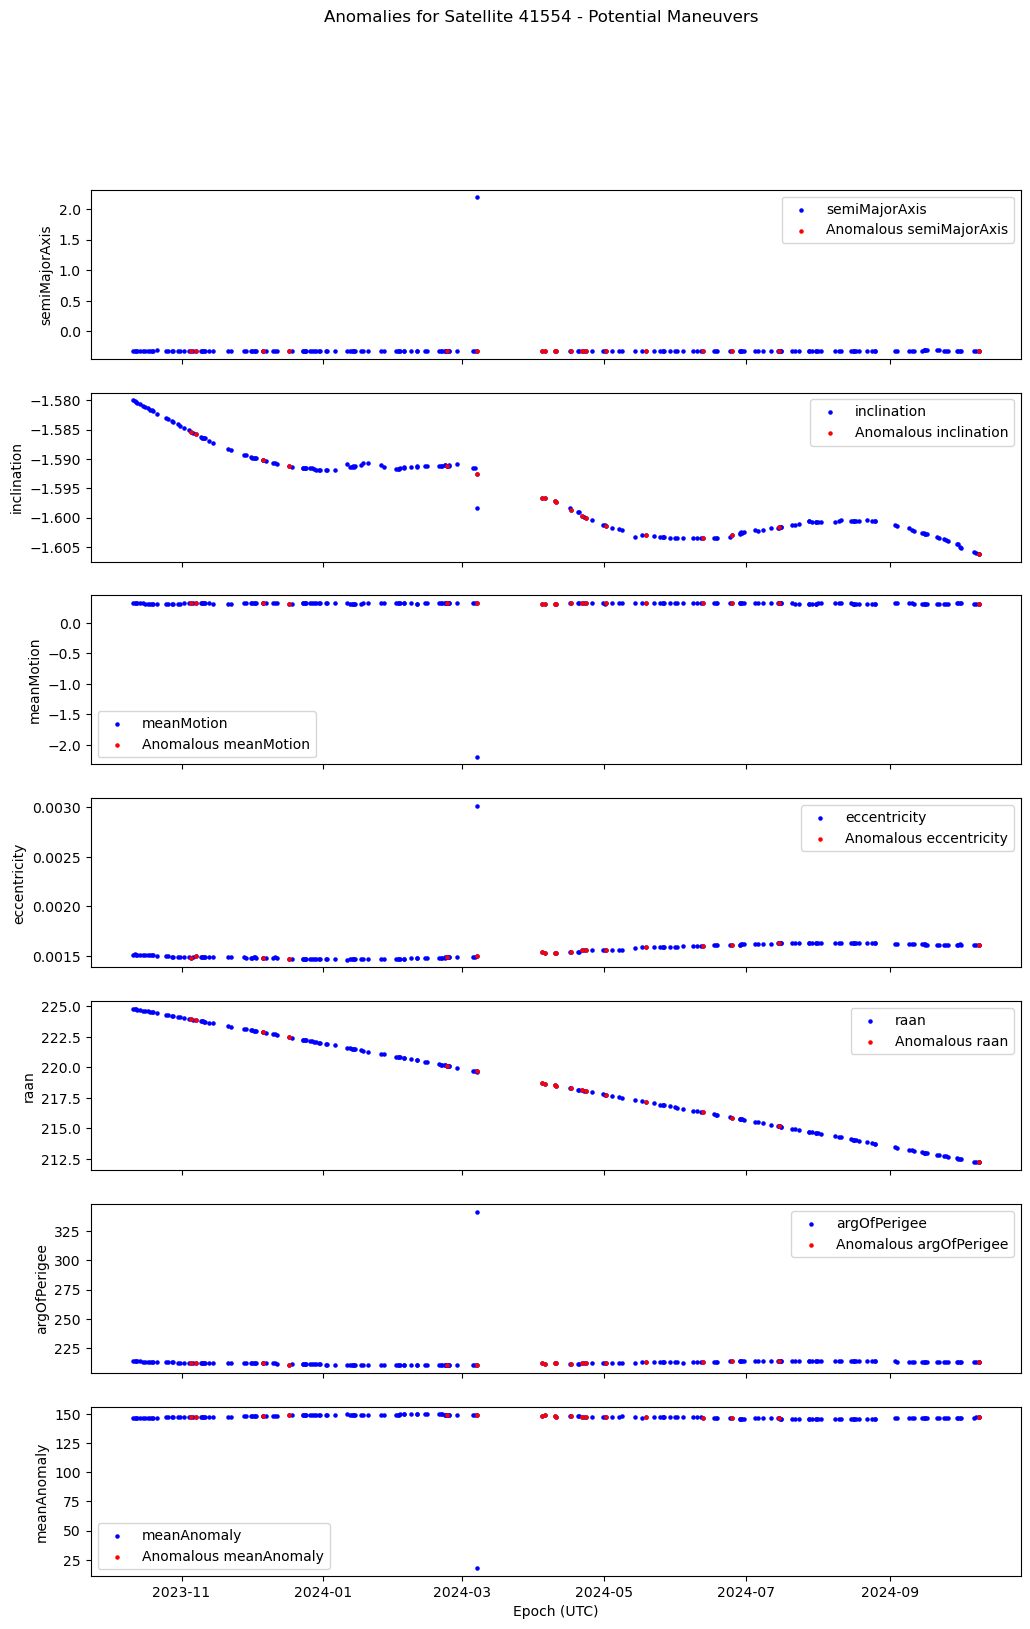

Processing satellite 42939


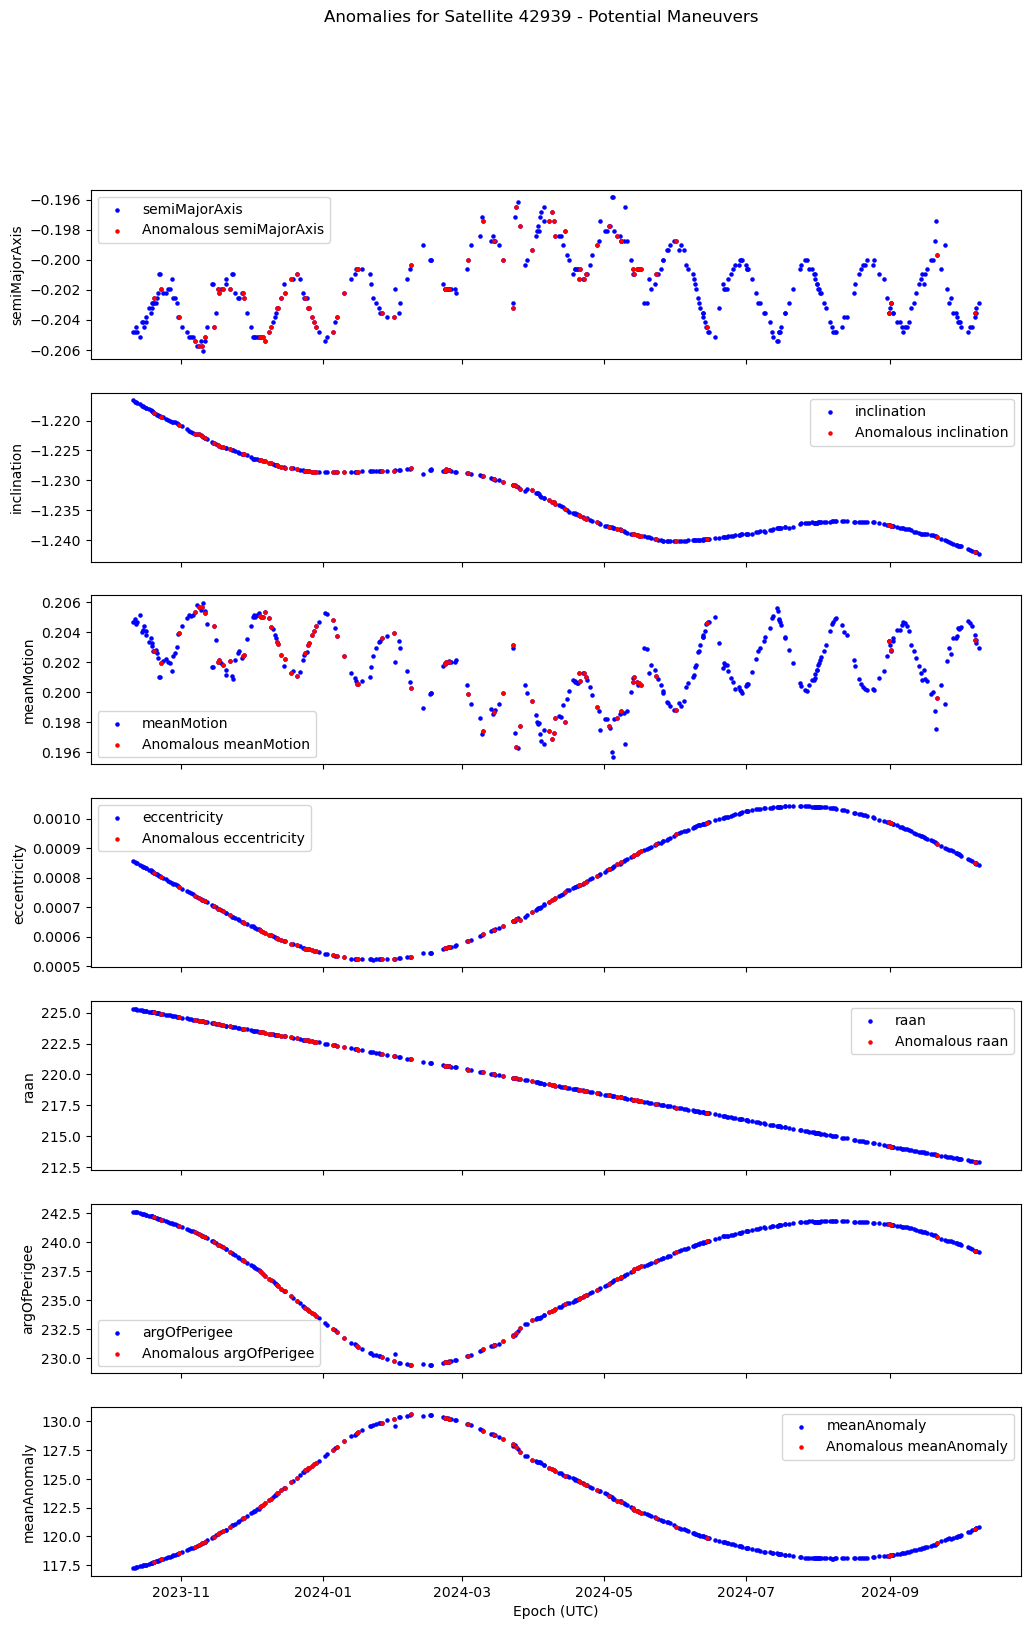

Processing satellite 43508


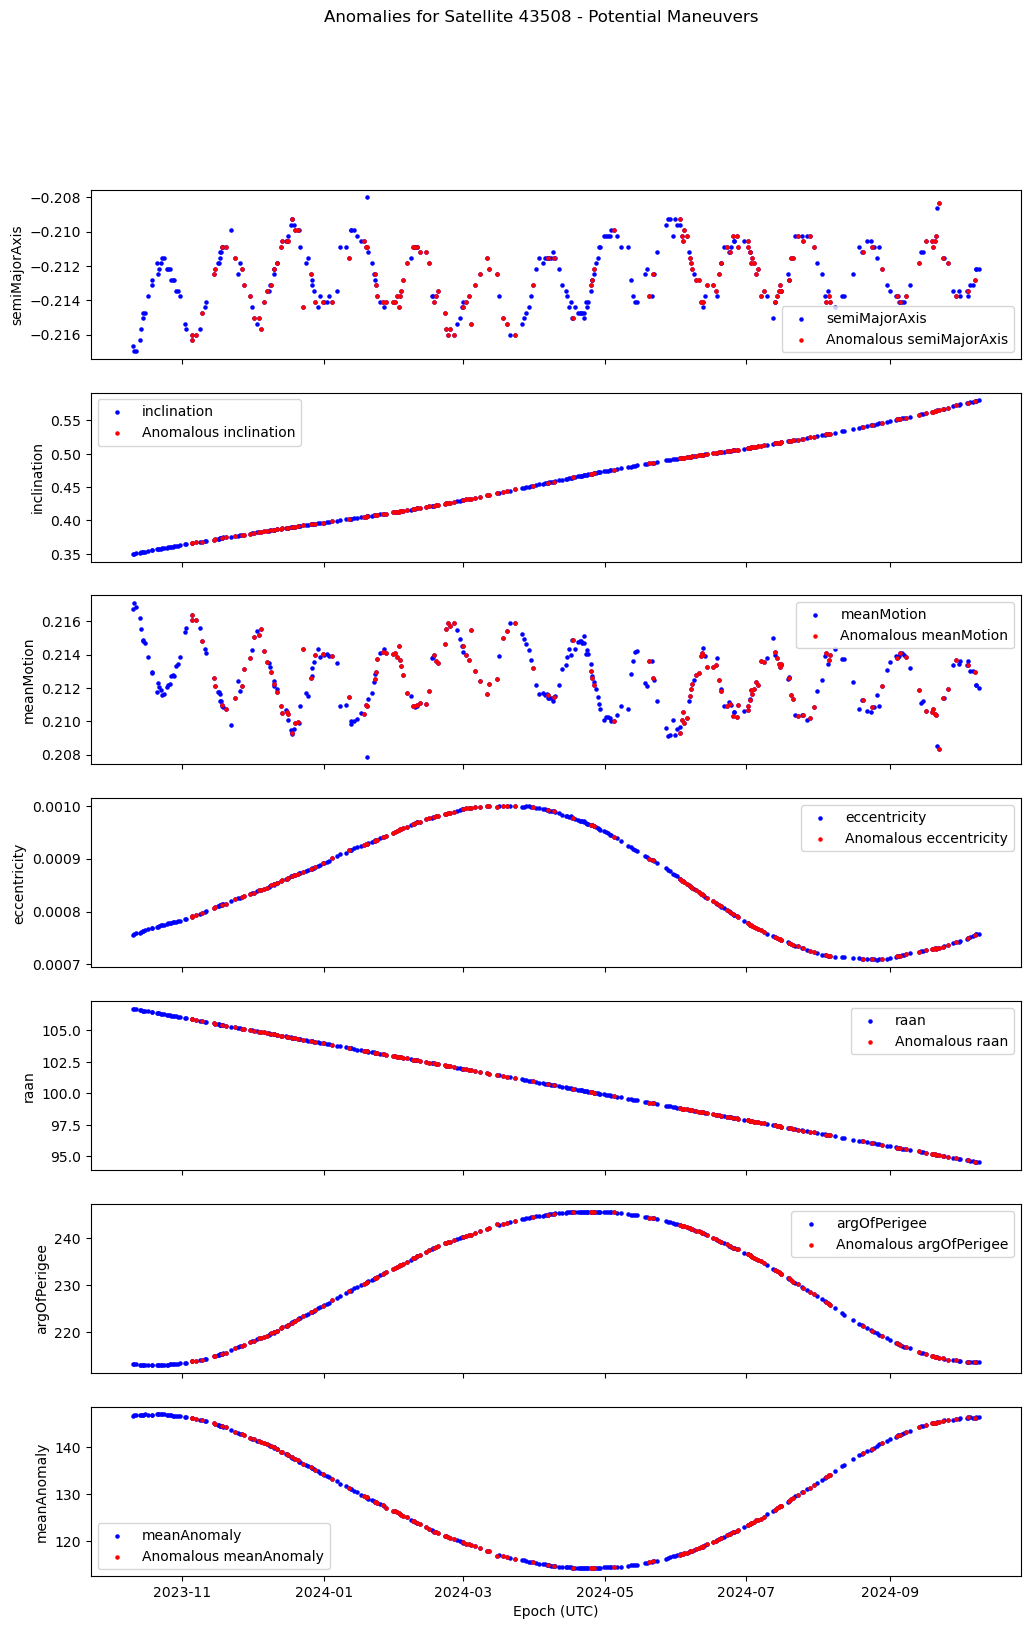

Processing satellite 43687


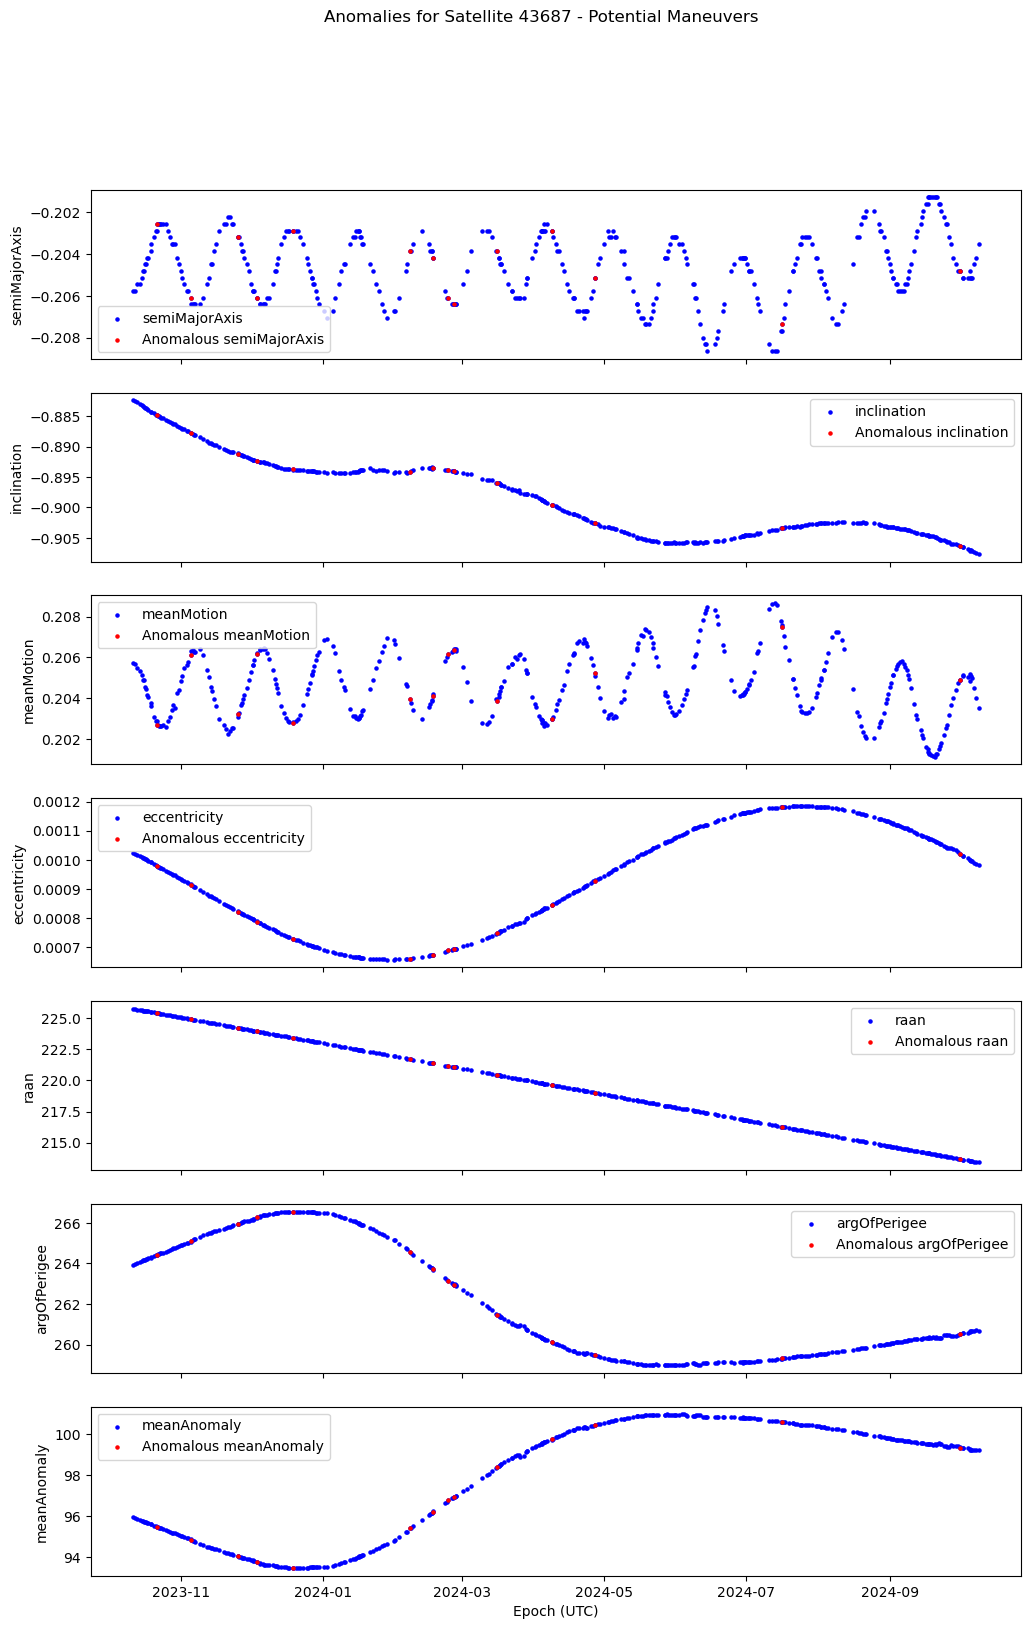

Processing satellite 44299


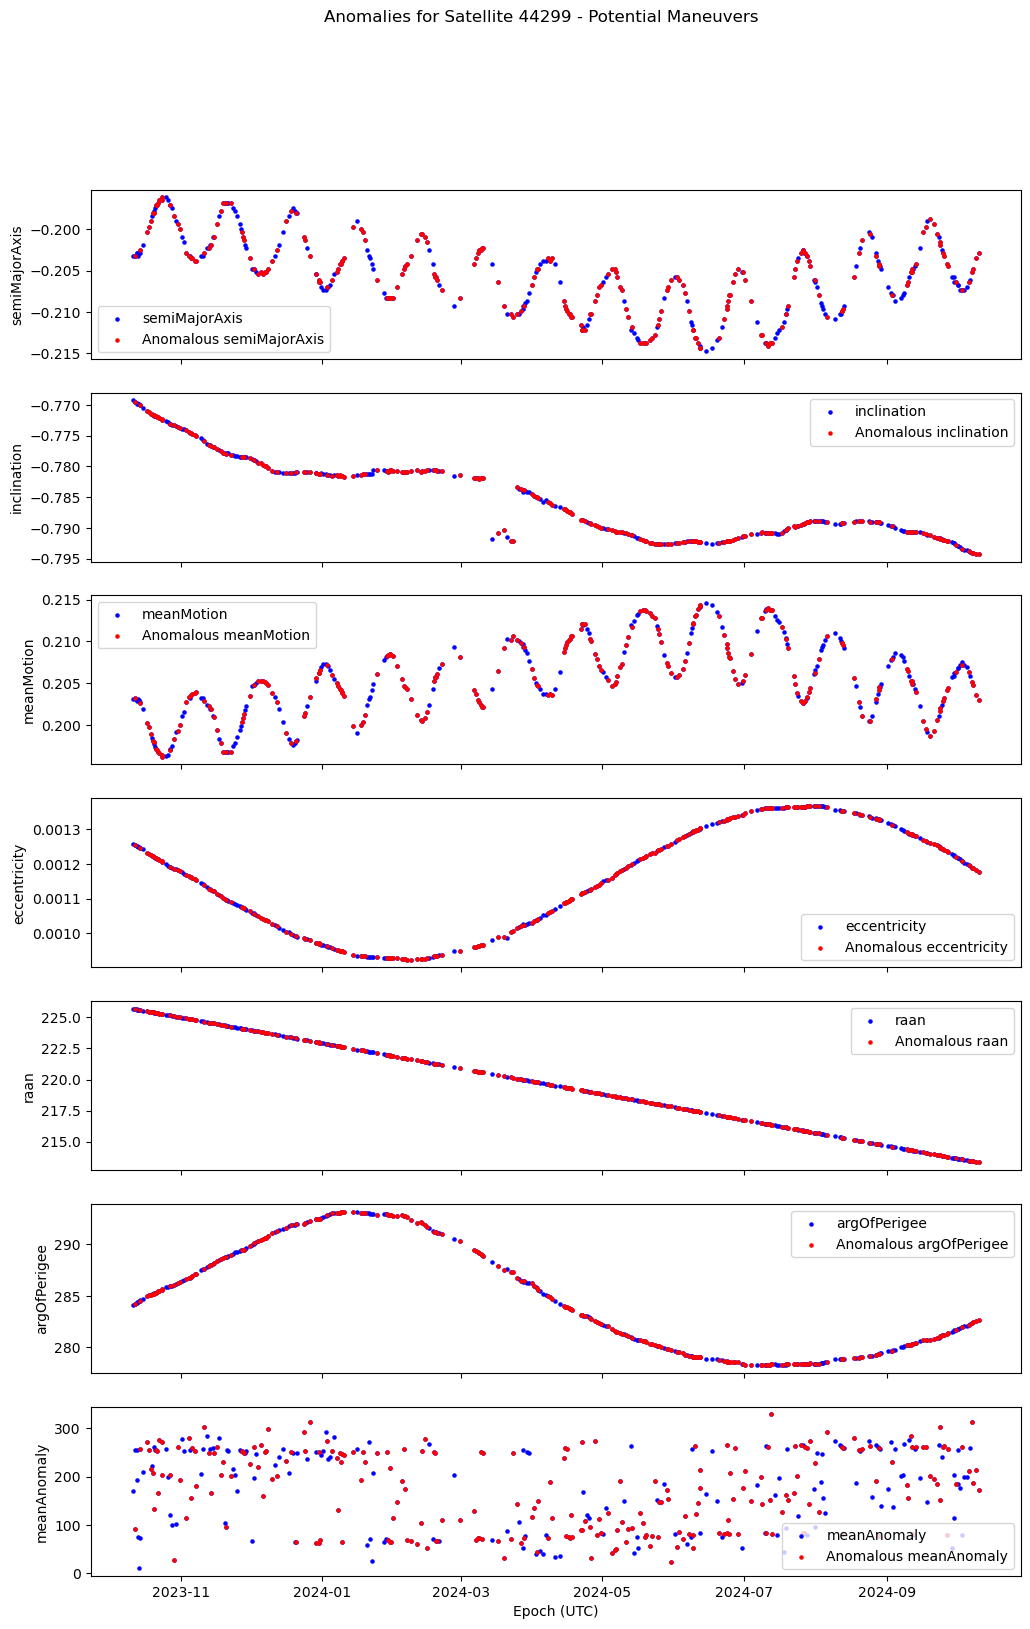

Processing satellite 44850


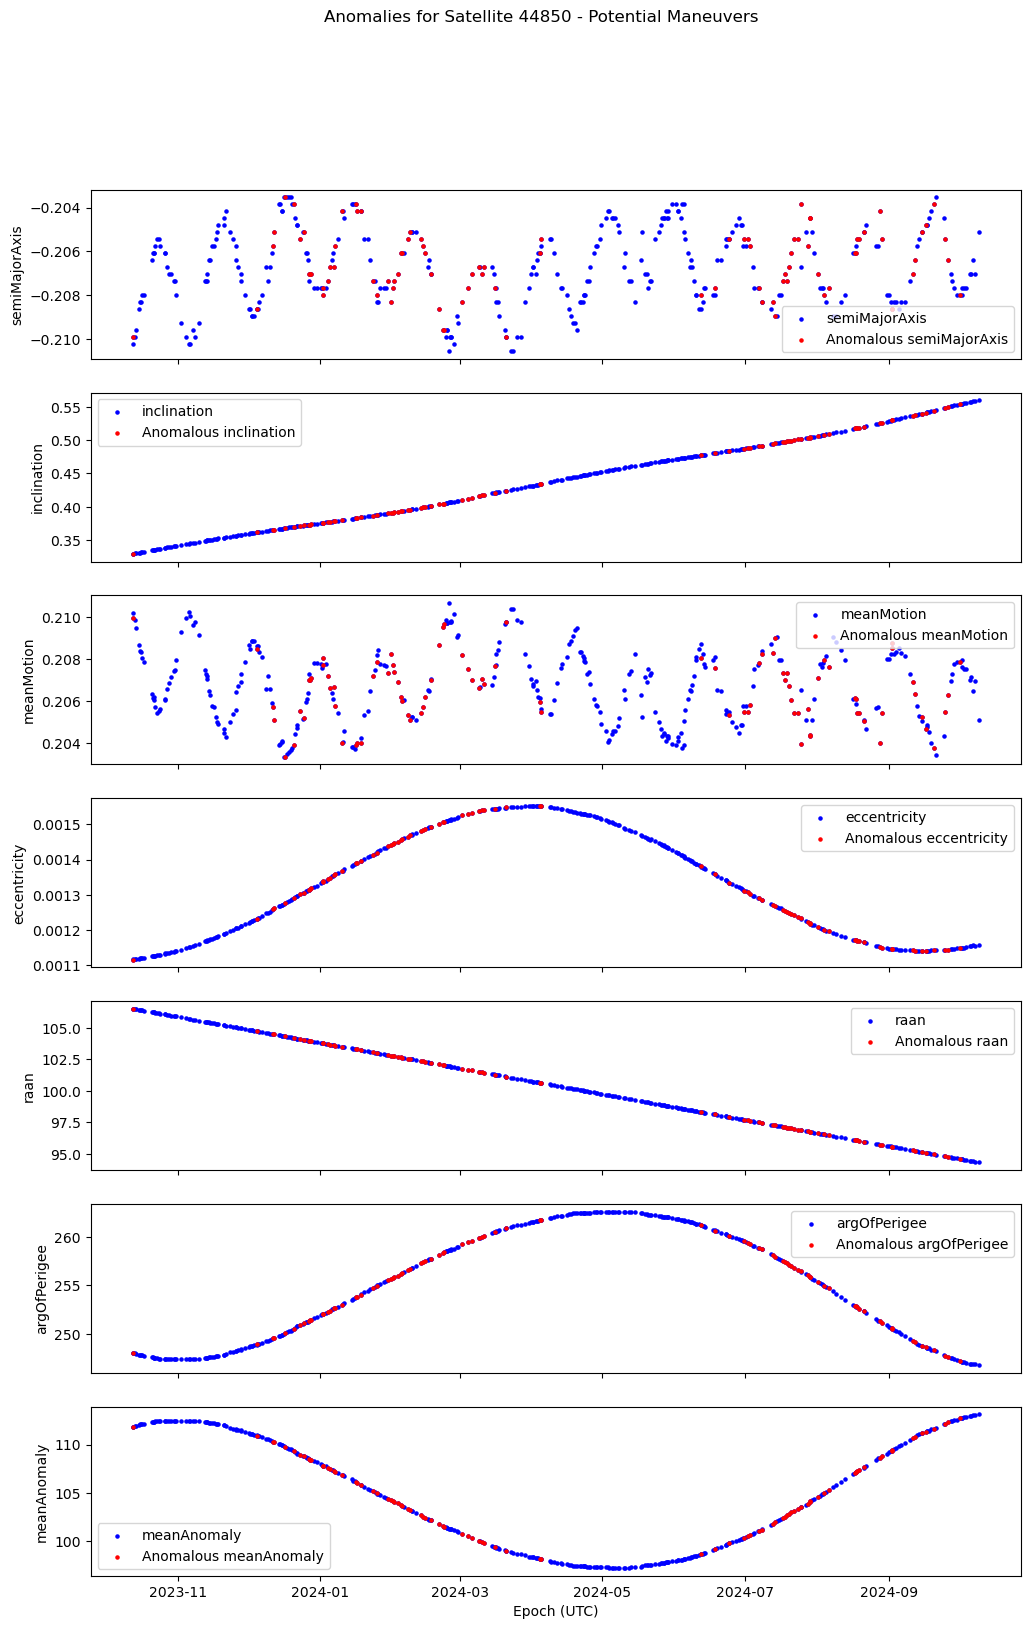

Processing satellite 45358


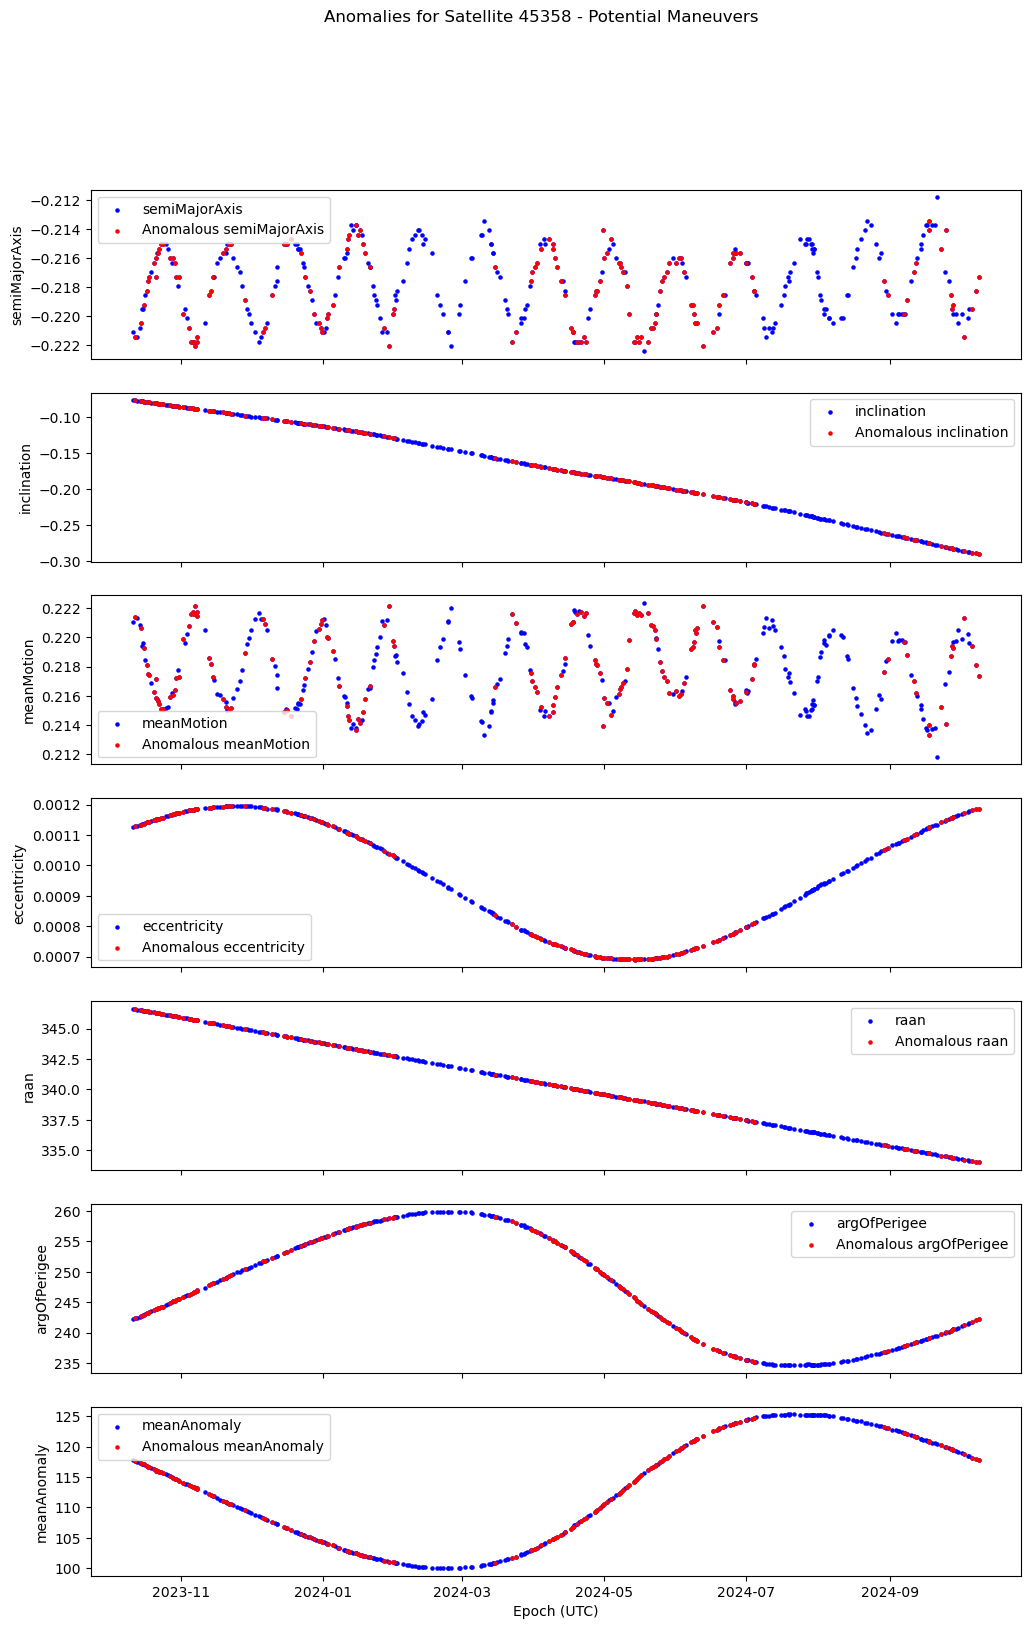

Processing satellite 46805


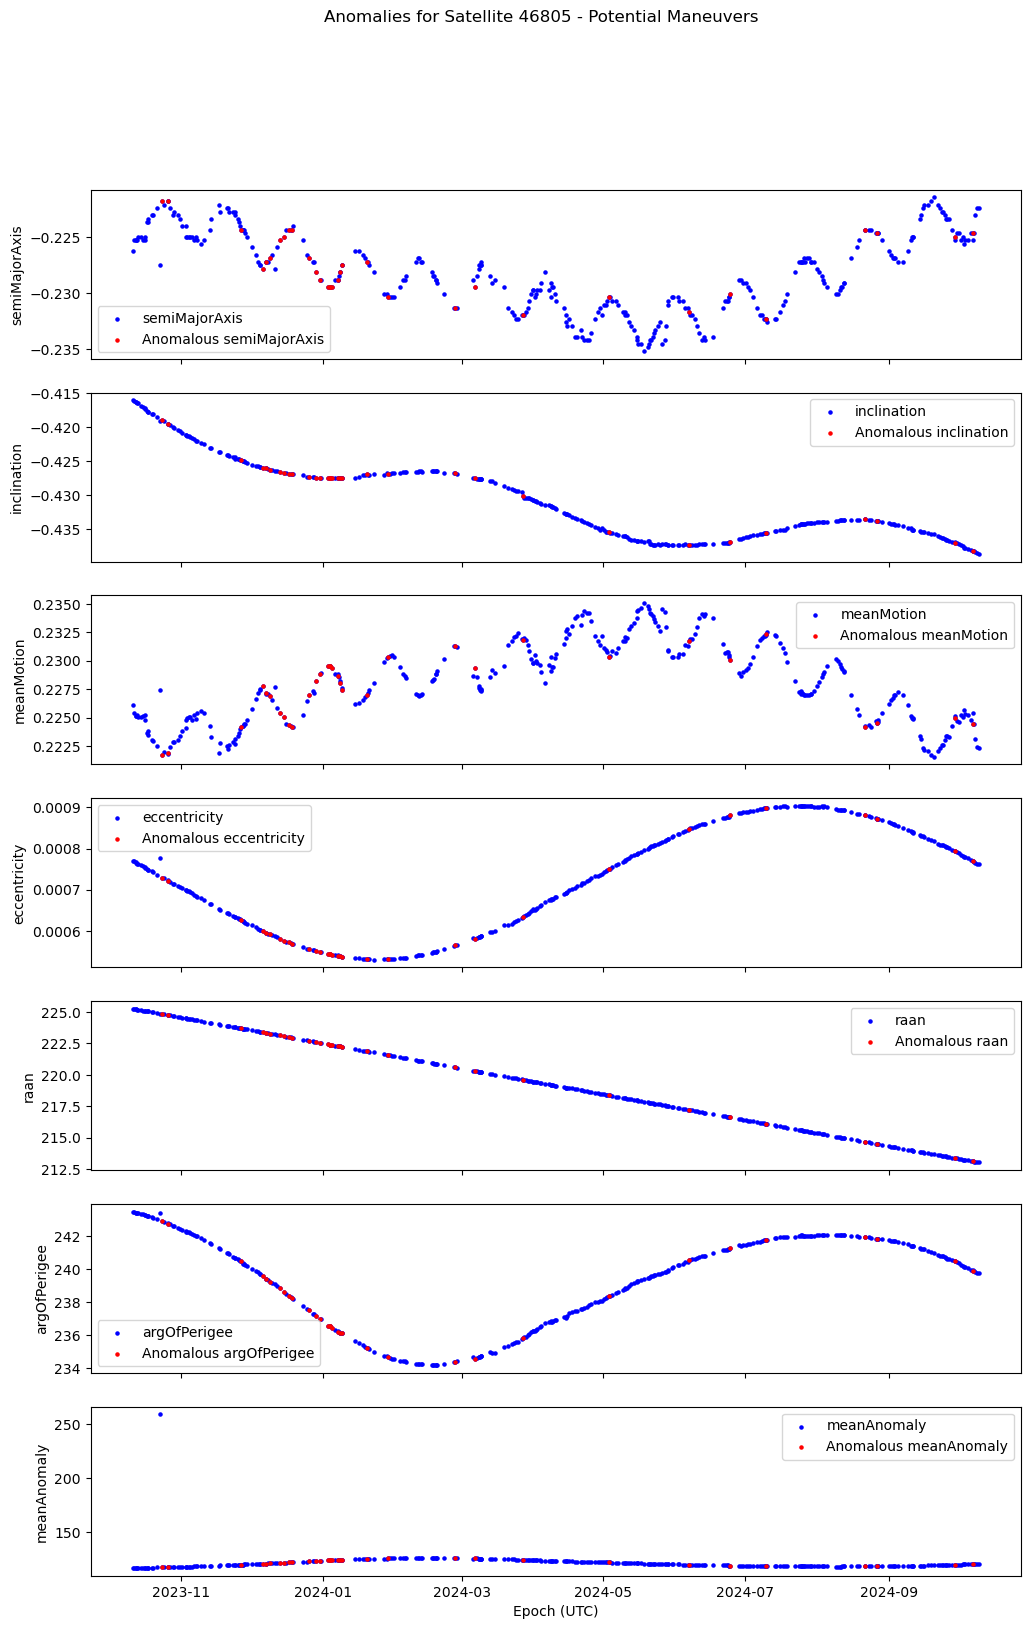

Processing satellite 52984


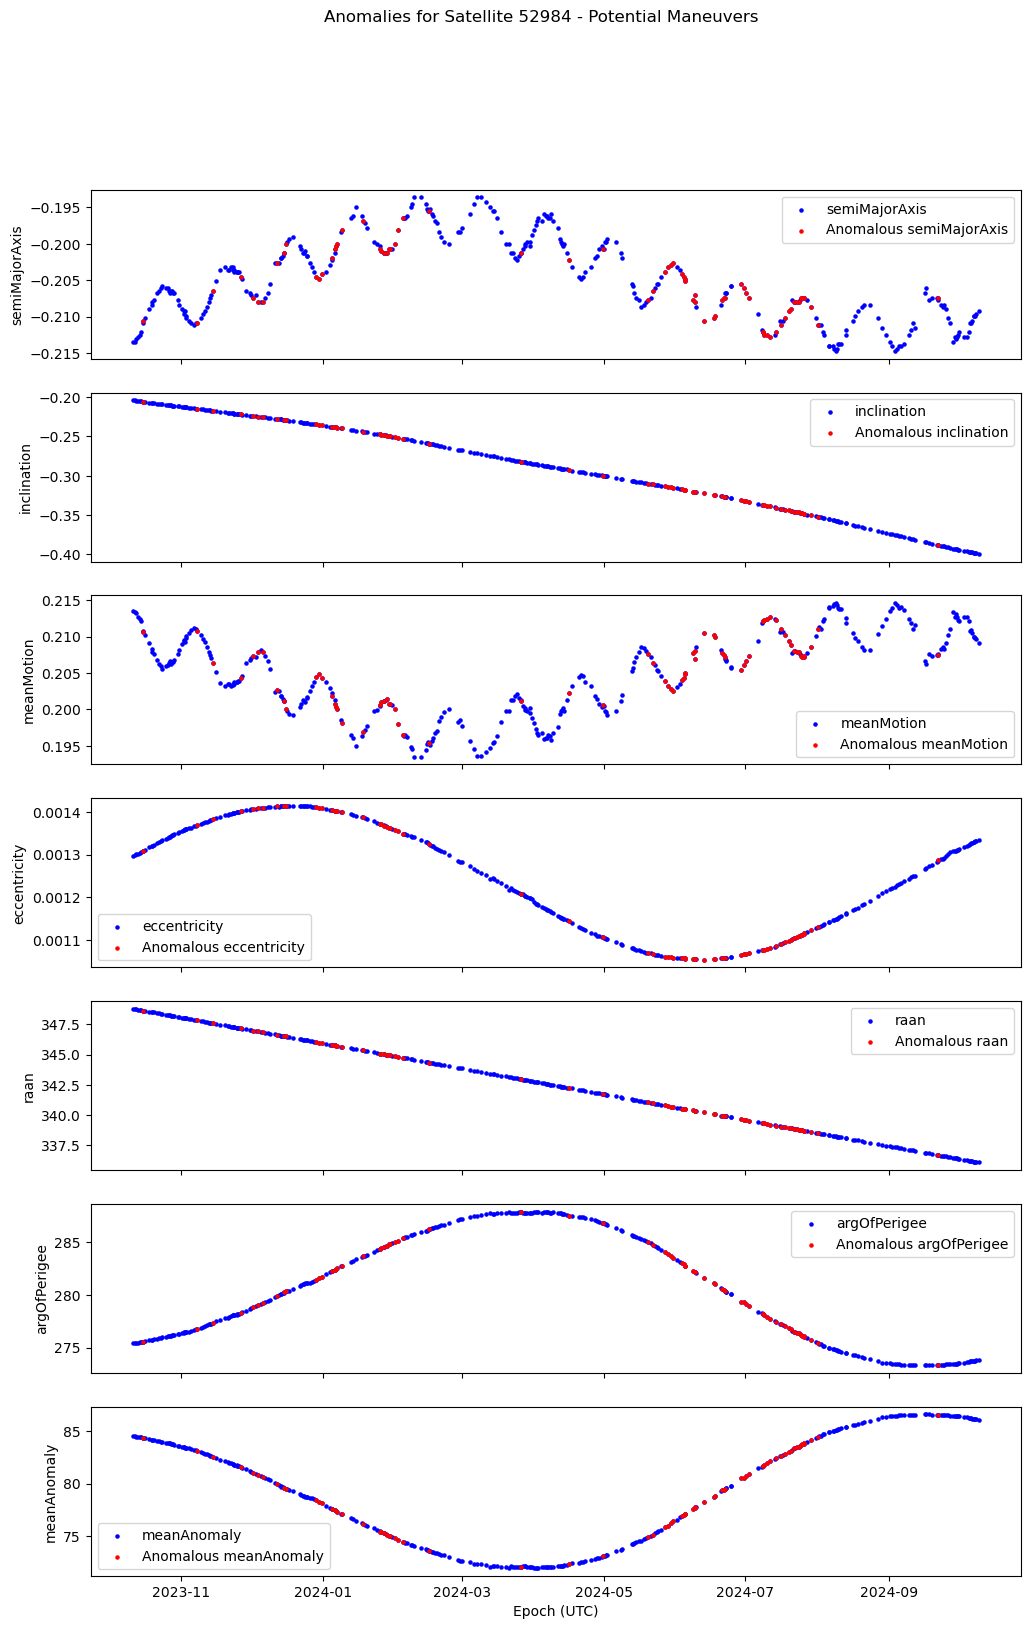

Processing satellite 54031


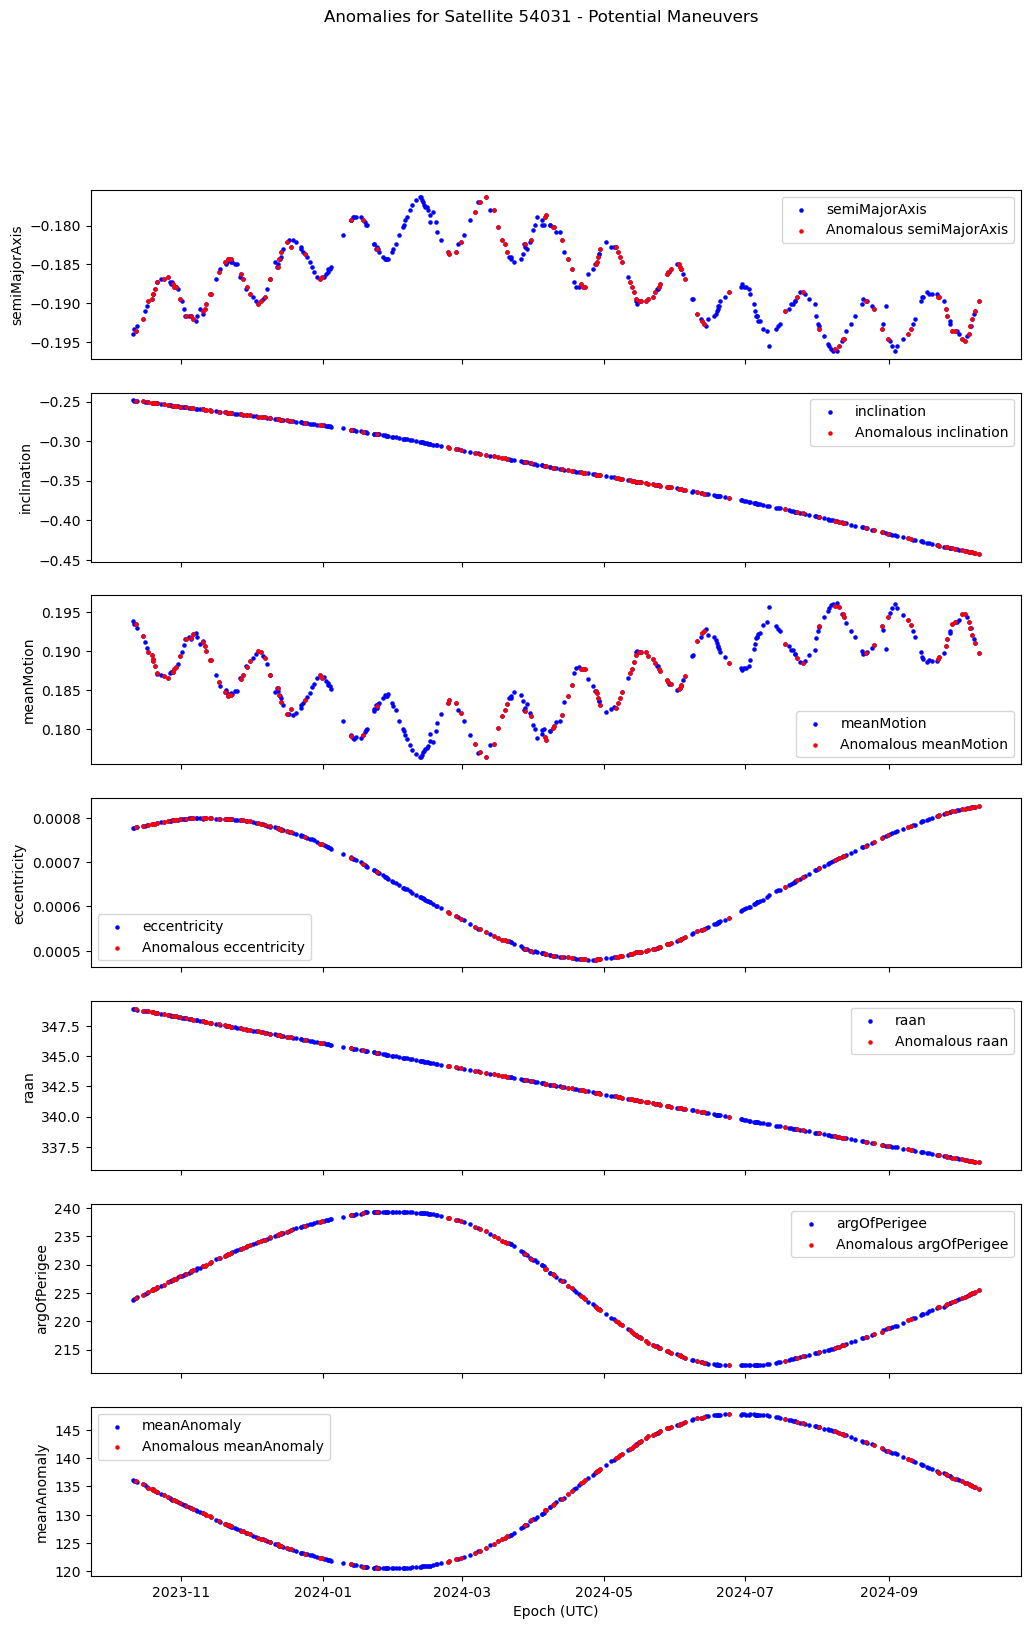

Total anomalies detected: 4659


In [31]:
def detect_and_visualize_anomalies_with_subplots(data, semi_major_axis_threshold=10, inclination_threshold=0.1,
                                                 mean_motion_threshold=0.05, eccentricity_threshold=0.001,
                                                 raan_threshold=0.1, arg_of_perigee_threshold=0.1, mean_anomaly_threshold=0.1):
    """
    Detects and visualizes anomalies in satellite data using subplots for each feature.
    
    Parameters:
    - data: DataFrame containing satellite data with relevant columns.
    - semi_major_axis_threshold, inclination_threshold, mean_motion_threshold, eccentricity_threshold,
      raan_threshold, arg_of_perigee_threshold, mean_anomaly_threshold: Thresholds for significant changes
      in each respective feature.
    """
    
    def calculate_rate_of_change(group, feature, time_column='epoch'):
        delta_feature = group[feature].diff().abs()
        delta_time = group[time_column].diff().dt.total_seconds() / (3600 * 24)  # convert to days
        return delta_feature / delta_time

    # Define feature thresholds for anomaly detection
    feature_thresholds = {
        'semiMajorAxis': semi_major_axis_threshold,
        'inclination': inclination_threshold,
        'meanMotion': mean_motion_threshold,
        'eccentricity': eccentricity_threshold,
        'raan': raan_threshold,
        'argOfPerigee': arg_of_perigee_threshold,
        'meanAnomaly': mean_anomaly_threshold
    }
    
    # Detect anomalies for each satellite
    grouped = data.groupby('satNo')
    all_anomalies = []
    features_to_plot = list(feature_thresholds.keys())

    for sat_no, sat_group in grouped:
        print(f"Processing satellite {sat_no}")
        
        # Preprocess 'epoch' column
        sat_group['epoch'] = pd.to_datetime(sat_group['epoch'], errors='coerce').dropna().sort_values()
        if sat_group['epoch'].dt.tz is None:
            sat_group['epoch'] = sat_group['epoch'].dt.tz_localize('UTC')

        # Calculate rate of change for each feature
        for feature in features_to_plot:
            sat_group[f'{feature}_rate_of_change'] = calculate_rate_of_change(sat_group, feature)

        # Identify anomalies based on thresholds
        anomalies = pd.concat(
            [sat_group[sat_group[f'{feature}_rate_of_change'] > feature_thresholds[feature]] for feature in features_to_plot]
        ).drop_duplicates()

        if not anomalies.empty:
            all_anomalies.append(anomalies)

            # Plot each feature in a separate subplot
            fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(12, 18), sharex=True)
            fig.suptitle(f"Anomalies for Satellite {sat_no} - Potential Maneuvers")

            for idx, feature in enumerate(features_to_plot):
                # Plot feature as scatter instead of line
                axes[idx].scatter(sat_group['epoch'], sat_group[feature], label=feature, color='blue', s=5)
                anomaly_points = anomalies['epoch'][anomalies[feature].notna()]
                anomaly_values = anomalies[feature][anomalies[feature].notna()]
                axes[idx].scatter(anomaly_points, anomaly_values, color='red', label=f'Anomalous {feature}', s=5)
                axes[idx].set_ylabel(f'{feature}')
                axes[idx].legend()

            plt.xlabel('Epoch (UTC)')
            plt.show()

    # Combine all anomalies
    combined_anomalies = pd.concat(all_anomalies, axis=0)
    
    # Print total number of anomalies detected
    print(f"Total anomalies detected: {combined_anomalies.shape[0]}")
    return combined_anomalies

# Call the function with RU_PNT_SAT data
combined_anomalies = detect_and_visualize_anomalies_with_subplots(RU_PNT_SAT)


## OPTICS (Ordering Points To Identify the Clustering Structure)

Density-based Clustering: OPTICS is particularly good at identifying clusters of varying densities, which is useful in scenarios where some satellite movements might follow tight, controlled patterns while others might have larger deviations (possibly intentional).

Hierarchical Clustering: Unlike DBSCAN, OPTICS allows for the creation of hierarchical clusters, which can help in identifying outliers that don't belong to any cluster and track shifts in movement patterns more accurately.

No Need to Specify Cluster Count: Similar to DBSCAN, you don’t need to pre-define the number of clusters. This can be useful when analyzing satellite data, where the number of clusters (potential movement patterns or anomalies) isn’t always known.

Detection of Both Anomalous Clusters and Points: OPTICS provides a reachability plot that can highlight outliers that don't belong to any particular cluster, making it ideal for detecting satellites with potential intentional movement.

### Benefits of Using OPTICS Over Manual Thresholding (Previous Code)

**No Need for Manual Thresholds:** 
   - In the manual method, you needed to establish specific thresholds for each feature (e.g., rate of change in semiMajorAxis, inclination, etc.), which can be challenging to set accurately, especially if you don't know the underlying distributions or typical variances of the features.
   - OPTICS, being a density-based clustering algorithm, does not require feature-specific thresholds. Instead, it finds clusters based on density, marking points that don’t belong to any cluster as outliers. This approach is more flexible and reduces the need for domain-specific expertise to define thresholds.

**Handles Multi-Dimensional Data Naturally:**
   - The manual method required setting individual thresholds for each feature separately, which can be problematic for multi-dimensional data with complex interactions between features.
   - OPTICS can handle multi-dimensional data seamlessly, taking all features into account simultaneously. This allows it to identify anomalies based on the combined effect of multiple features, making it better suited for detecting complex patterns that may not be obvious in single-feature analyses.

**Automatically Adjusts to Density Variations:**
   - OPTICS is specifically designed to handle variations in data density. Unlike fixed-threshold methods, it can adapt to areas of high and low density within the same dataset. This is useful in datasets like satellite data, where certain behaviors might cluster more densely while others are spread out.
   - This adaptability allows OPTICS to detect anomalies in both sparse and dense regions of the feature space without additional tuning.

**Suitable for Non-Spherical Clusters:**
   - Traditional clustering methods (like k-means) assume clusters are spherical, which often doesn't align with real-world data, especially multi-dimensional time series data with various orbital parameters.
   - OPTICS, however, can detect clusters of arbitrary shapes, making it better suited for data where anomalies or normal behaviors might form elongated, irregular, or connected patterns.

**Less Sensitive to Scale:**
   - By combining features and standardizing them, OPTICS considers the overall structure of the data rather than relying on individual scales of features. While the manual method also involved scaling, setting thresholds for each feature still required understanding how each feature behaves individually.
   - With OPTICS, once features are scaled, it applies density-based clustering across the entire dataset without requiring further feature-specific adjustments.

**Identifies Outliers Naturally:**
   - OPTICS automatically flags points that don’t belong to any cluster as outliers (or anomalies) without needing to define what qualifies as "anomalous behavior" in advance.
   - In contrast, the manual approach requires setting specific criteria (thresholds) to label a point as an anomaly. This might lead to false positives or false negatives if the thresholds are not accurately tuned for the dataset.

**Adaptability for New Data:**
   - OPTICS provides a more adaptable approach that can scale to new or updated datasets. You can retrain the model on new data without revisiting feature-specific thresholds.
   - In contrast, with the manual method, you would need to periodically review and potentially adjust thresholds as new data is introduced or as patterns evolve over time.


### Methodology:

**1. Custom Scoring Function for OPTICS:** A custom scoring function, optics_silhouette_scorer, uses the silhouette score to evaluate the quality of clustering produced by OPTICS. This function helps identify the best hyperparameters for the OPTICS model by maximizing the silhouette score across different configurations. The silhouette score is only calculated if the model generates more than one label (i.e., more than one cluster); otherwise, it returns a default score of -1.

**2. Define Hyperparameter Space:** A range of values is defined for key OPTICS parameters: min_samples (the minimum number of samples in a cluster) and max_eps (the maximum radius for clustering). These values determine the OPTICS model's sensitivity to clusters and anomalies, and they will be optimized to improve clustering performance.

**3. Prepare the Dataset for Hyperparameter Tuning:** The dataset is grouped by each unique satellite ID (satNo) to ensure that each satellite's data is processed individually. Seven orbital features (semiMajorAxis, inclination, meanMotion, eccentricity, raan, argOfPerigee, and meanAnomaly) are selected for clustering. These features capture important aspects of a satellite's orbit and are crucial for identifying potential anomalies.

**4. Preprocessing (Imputation and Scaling):**

    a. Imputation: Missing values in each feature are filled with the mean of the respective feature using SimpleImputer. This ensures no missing values interfere with the clustering process.

    b. Normalization: Each feature is standardized (mean-centered and scaled to unit variance) using StandardScaler to ensure all features contribute equally to the clustering.

**5. Combine Data for Global Hyperparameter Tuning:** The imputed and scaled data for each satellite is combined into a single global dataset, global_data. This consolidated dataset will be used to perform hyperparameter tuning for the OPTICS model.

**6. Hyperparameter Tuning with RandomizedSearchCV:** 

    a. RandomizedSearchCV is used to explore different values of min_samples and max_eps for the OPTICS model, using a cross-validation strategy (5-fold) to evaluate each configuration.

    b. A custom subclass, PrintingRandomizedSearchCV, is created to print the hyperparameters currently being tested, providing real-time feedback during the tuning process.

    c. The silhouette score is used as the scoring metric to identify the best combination of parameters for clustering.

**7. Identify Optimal Parameters:** After tuning, the best values for min_samples and max_eps are stored in best_params, representing the configuration that achieved the highest silhouette score. These parameters are saved for later use in applying the OPTICS model.

**8. Initialize and Apply the OPTICS Model:** 

    a. An OPTICS model is initialized with the optimized parameters from best_params and applied to the entire RU_PNT_SAT dataset.

    b. Before clustering, the same preprocessing steps (imputation and scaling) are applied to RU_PNT_SAT to prepare the data for clustering.

**9. Cluster Analysis and Anomaly Detection:**

    a. The OPTICS model assigns a label to each data point in RU_PNT_SAT based on clustering results. Points with a label of -1 are considered outliers or anomalies.

    b. A new column, Anomaly, is added to the RU_PNT_SAT DataFrame, marking rows with True if they are identified as anomalies (label -1), and False otherwise.

**10. Review and Validate Anomalies:** The results, including the anomaly labels, are printed for inspection. A subset of the RU_PNT_SAT DataFrame, including key features and the Anomaly column, is displayed to verify that anomalies are accurately identified.

In [32]:
# Define a custom scoring function for OPTICS using silhouette score
def optics_silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        return -1

# Define the hyperparameter space for OPTICS
param_distributions = {
    'min_samples': [5, 10, 15, 25, 50],
    'max_eps': [0.5, 1.0, 1.5, 2.0, 2.5]
}

# Prepare combined dataset for global hyperparameter tuning on all relevant features
features_to_include = ['semiMajorAxis', 'inclination', 'meanMotion', 'eccentricity', 'raan', 'argOfPerigee', 'meanAnomaly']
grouped = RU_PNT_SAT.groupby('satNo')
sampled_data = []

for _, sat_group in grouped:
    # Input missing values and scale features
    sat_group[features_to_include] = SimpleImputer(strategy='mean').fit_transform(sat_group[features_to_include])
    sat_group[features_to_include] = StandardScaler().fit_transform(sat_group[features_to_include])
    sampled_data.append(sat_group[features_to_include])

# Combine for a global dataset
global_data = pd.concat(sampled_data).values

# Create OPTICS model for hyperparameter tuning
optics_model = OPTICS()
cv = KFold(n_splits=5)

# Add custom print statements within RandomizedSearchCV's fit function
class PrintingRandomizedSearchCV(RandomizedSearchCV):
    def fit(self, X, y=None, **fit_params):
        for params in self.param_distributions:
            print(f"Testing hyperparameters: {params}")
        super().fit(X, y=y, **fit_params)

# Perform global hyperparameter tuning with custom print statements
global_search = PrintingRandomizedSearchCV(
    estimator=optics_model,
    param_distributions=param_distributions,
    n_iter=10,
    random_state=42,
    scoring=optics_silhouette_scorer,
    cv=cv
)

# Execute the search
print("Starting hyperparameter tuning...")
global_search.fit(global_data)
best_params = global_search.best_params_

# Print the best hyperparameters found
print(f"Best hyperparameters identified: {best_params}")

# Save the best parameters to a variable for later use
saved_best_params = best_params

Starting hyperparameter tuning...
Testing hyperparameters: min_samples
Testing hyperparameters: max_eps
Best hyperparameters identified: {'min_samples': 5, 'max_eps': 1.0}


In [109]:
# Initialize OPTICS with the best parameters
optics_model = OPTICS(min_samples=saved_best_params['min_samples'], max_eps=saved_best_params['max_eps'])

# Make a copy of RU_PNT_SAT to avoid the SettingWithCopyWarning
RU_PNT_SAT_copy = RU_PNT_SAT.copy()

# Preprocess the RU_PNT_SAT data by imputing missing values and scaling features
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Select all relevant columns for clustering
features_to_cluster = ['semiMajorAxis', 'inclination', 'meanMotion', 'eccentricity', 'raan', 'argOfPerigee', 'meanAnomaly']
RU_PNT_SAT_copy[features_to_cluster] = imputer.fit_transform(RU_PNT_SAT_copy[features_to_cluster])
RU_PNT_SAT_copy[features_to_cluster] = scaler.fit_transform(RU_PNT_SAT_copy[features_to_cluster])

# Apply the OPTICS model to the data
labels = optics_model.fit_predict(RU_PNT_SAT_copy[features_to_cluster])

# Add a new column 'Anomaly' to indicate anomalies (-1 label means anomalous in OPTICS)
RU_PNT_SAT_copy['Anomaly'] = labels == -1  # True for anomalies, False otherwise

# Display a few rows to verify the anomaly labeling
RU_PNT_SAT_copy[['epoch', 'satNo', 'semiMajorAxis', 'inclination', 'meanMotion', 
                       'eccentricity', 'raan', 'argOfPerigee', 'meanAnomaly', 'Anomaly']].head()

epoch  satNo  semiMajorAxis  inclination  meanMotion  eccentricity  raan  argOfPerigee  meanAnomaly  Anomaly
29711  2024-01-21T00:52:42.563136Z  29671              3           -0          -3             1    -0            -1            0     True
29712  2024-09-30T08:13:07.427712Z  29671              3           -0          -3             1    -0            -1            3    False
29713  2024-09-28T08:47:51.707616Z  29671              3           -0          -3             1    -0            -1            2    False
29714  2024-09-26T14:38:55.265568Z  29671              3           -0          -3             1    -0            -1           -2    False
29715  2024-02-16T10:01:08.580288Z  29671              3           -0          -3             1    -0            -1            1     True

In [110]:
# Rename the existing 'epoch' column to 'datetime_stamp'
RU_PNT_SAT_copy.rename(columns={'epoch': 'datetime_stamp'}, inplace=True)

# Convert the datetime_stamp column to datetime format, if not already
RU_PNT_SAT_copy['datetime_stamp'] = pd.to_datetime(RU_PNT_SAT_copy['datetime_stamp'], errors='coerce')

# Create a new 'epoch' column with Unix timestamps (epoch time in seconds)
RU_PNT_SAT_copy['epoch'] = RU_PNT_SAT_copy['datetime_stamp'].apply(lambda x: int(x.timestamp()) if pd.notnull(x) else float('nan'))

RU_PNT_SAT_copy.head()

satNo COUNTRY OBJECT_TYPE Country of Operator/Owner                        Purpose                   datetime_stamp  meanMotion  eccentricity  inclination  raan  argOfPerigee  meanAnomaly  meanMotionDot  meanMotionDDot  semiMajorAxis  apogee  perigee  Anomaly       epoch
29711  29671     CIS     PAYLOAD                    Russia  Navigation/Global Positioning 2024-01-21 00:52:42.563136+00:00          -3             1           -0    -0            -1            0              0               0              3   25573    25465     True  1705798362
29712  29671     CIS     PAYLOAD                    Russia  Navigation/Global Positioning 2024-09-30 08:13:07.427712+00:00          -3             1           -0    -0            -1            3             -0               0              3   25574    25464    False  1727683987
29713  29671     CIS     PAYLOAD                    Russia  Navigation/Global Positioning 2024-09-28 08:47:51.707616+00:00          -3             1           -0    -0            -1            2             -0               0              3   25574    25464    False  1727513271
29714  29671     CIS     PAYLOAD                    Russia  Navigation/Global Positioning 2024-09-26 14:38:55.265568+00:00          -3             1           -0    -0            -1           -2             -0               0              3   25574    25464    False  1727361535
29715  29671     CIS     PAYLOAD                    Russia  Navigation/Global Positioning 2024-02-16 10:01:08.580288+00:00          -3             1           -0    -0            -1            1              0               0              3   25573    25465     True  1708077668

In [111]:
# Examine how many anomalies were detected, looks like 3840
RU_PNT_SAT_copy['Anomaly'].value_counts()

Anomaly
False    6771
True     3840
Name: count, dtype: int64

### Russian Rocket Attacks on Ukraine

In [100]:
# Load the dataset to examine its contents
missile = 'missile_attacks_daily.csv'
df_missile = pd.read_csv(missile)
df_missile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1810 entries, 0 to 1809
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time_start            1810 non-null   object 
 1   time_end              1810 non-null   object 
 2   model                 1810 non-null   object 
 3   launch_place          890 non-null    object 
 4   target                1782 non-null   object 
 5   carrier               208 non-null    object 
 6   launched              1807 non-null   float64
 7   destroyed             1810 non-null   int64  
 8   not_reach_goal        85 non-null     float64
 9   cross_border_belarus  16 non-null     float64
 10  back_russia           19 non-null     float64
 11  still_attacking       13 non-null     float64
 12  destroyed_details     222 non-null    object 
 13  launched_details      1 non-null      object 
 14  launch_place_details  1 non-null      object 
 15  source               

In [101]:
# Gathering the relevent fields
# time_start = start attack time
# time_end = end attack time
# model = missile or UAV type
# target = location in Ukraine
# launched = number of launched missiles or UAVs

df_missile = df_missile[['time_start', 'time_end', 'model', 'target', 'launched']]
df_missile.head()

time_start          time_end           model   target  launched
0  2024-10-02 17:30  2024-11-03 09:00       X-59/X-69  Ukraine         1
1  2024-10-02 17:30  2024-11-03 09:00  Shahed-136/131  Ukraine        96
2  2024-11-01 19:00  2024-11-02 11:00           X-31P  Ukraine         1
3  2024-11-01 19:00  2024-11-02 11:00  Shahed-136/131  Ukraine        71
4        2024-10-02        2024-11-02     Unknown UAV    south         1

In [102]:
# Make a copy of df_missile to create a cleaned version
df_missile_cleaned = df_missile.copy(deep=True)

# Ensure all entries in time_start and time_end have a time component
df_missile_cleaned['time_start'] = df_missile_cleaned['time_start'].apply(lambda x: f"{x} 00:00" if isinstance(x, str) and len(x) == 10 else x)
df_missile_cleaned['time_end'] = df_missile_cleaned['time_end'].apply(lambda x: f"{x} 23:59" if isinstance(x, str) and len(x) == 10 else x)

# Convert to datetime format, with NaT for any invalid entries
df_missile_cleaned['time_start'] = pd.to_datetime(df_missile_cleaned['time_start'], errors='coerce')
df_missile_cleaned['time_end'] = pd.to_datetime(df_missile_cleaned['time_end'], errors='coerce')

# Drop rows where either time_start or time_end is NaT
df_missile_cleaned.dropna(subset=['time_start', 'time_end'], inplace=True)

# Convert to Unix timestamp (epoch time in seconds)
df_missile_cleaned['time_start'] = df_missile_cleaned['time_start'].apply(lambda x: int(x.timestamp()))
df_missile_cleaned['time_end'] = df_missile_cleaned['time_end'].apply(lambda x: int(x.timestamp()))

df_missile_cleaned.head()

time_start    time_end           model   target  launched
0  1727890200  1730624400       X-59/X-69  Ukraine         1
1  1727890200  1730624400  Shahed-136/131  Ukraine        96
2  1730487600  1730545200           X-31P  Ukraine         1
3  1730487600  1730545200  Shahed-136/131  Ukraine        71
4  1727827200  1730591940     Unknown UAV    south         1

In [103]:
df_missile_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1808 entries, 0 to 1809
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time_start  1808 non-null   int64  
 1   time_end    1808 non-null   int64  
 2   model       1808 non-null   object 
 3   target      1780 non-null   object 
 4   launched    1805 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 84.8+ KB


In [114]:
# Ensure time_start and time_end in df_missile_cleaned are integers (Unix timestamps in seconds)
df_missile_cleaned['time_start'] = df_missile_cleaned['time_start'].astype(int)
df_missile_cleaned['time_end'] = df_missile_cleaned['time_end'].astype(int)

# Define a function to find the closest launch within the window and retrieve additional details
def closest_launch_info(epoch_time):
    # Filter df_missile_cleaned to find launches within the time window of each epoch
    launches_within_window = df_missile_cleaned[
        (df_missile_cleaned['time_start'] <= epoch_time) & 
        (df_missile_cleaned['time_end'] >= epoch_time)
    ]
    
    # If there are no launches within the window, return NaN for each value
    if launches_within_window.empty:
        return pd.Series([float('nan')] * 7, index=['diff_from_start', 'diff_from_end', 'launch_time_start', 'launch_time_end', 'launch_model', 'launch_target', 'launch_count'])
    
    # Find the closest launch time within the window
    closest_launch_idx = (launches_within_window['time_start'] - epoch_time).abs().argmin()
    closest_launch = launches_within_window.iloc[closest_launch_idx]
    
    # Calculate differences from both start and end times
    diff_from_start = epoch_time - closest_launch['time_start']
    diff_from_end = epoch_time - closest_launch['time_end']
    
    # Ensure time_start and time_end are integers
    launch_time_start = int(closest_launch['time_start'])
    launch_time_end = int(closest_launch['time_end'])
    
    # Return the differences and additional details as a Series
    return pd.Series(
        [diff_from_start, diff_from_end, launch_time_start, launch_time_end, closest_launch['model'], closest_launch['target'], closest_launch['launched']],
        index=['diff_from_start', 'diff_from_end', 'launch_time_start', 'launch_time_end', 'launch_model', 'launch_target', 'launch_count']
    )

# Initialize new columns with NaN
RU_PNT_SAT_copy[['diff_from_start', 'diff_from_end', 'launch_time_start', 'launch_time_end', 'launch_model', 'launch_target', 'launch_count']] = float('nan')

# Apply the function conditionally where Anomaly is True
RU_PNT_SAT_copy.loc[RU_PNT_SAT_copy['Anomaly'] == True, ['diff_from_start', 'diff_from_end', 'launch_time_start', 'launch_time_end', 'launch_model', 'launch_target', 'launch_count']] = \
    RU_PNT_SAT_copy.loc[RU_PNT_SAT_copy['Anomaly'] == True, 'epoch'].apply(closest_launch_info)

# Convert seconds to HH:MM:SS format
def convert_to_hhmmss(seconds):
    if pd.notnull(seconds):  # Check if seconds is not NaN
        return str(timedelta(seconds=abs(int(seconds))))
    else:
        return float('nan')

# Apply the conversion to diff_from_start and diff_from_end
RU_PNT_SAT_copy['diff_from_start'] = RU_PNT_SAT_copy['diff_from_start'].apply(convert_to_hhmmss)
RU_PNT_SAT_copy['diff_from_end'] = RU_PNT_SAT_copy['diff_from_end'].apply(convert_to_hhmmss)

# Display only the rows where Anomaly is True
anomalies_df = RU_PNT_SAT_copy[RU_PNT_SAT_copy['Anomaly'] == True]

anomalies_df[['datetime_stamp', 'epoch', 'diff_from_start', 'diff_from_end', 'launch_time_start', 'launch_time_end', 'launch_model', 'launch_target', 'launch_count', 'satNo', 'semiMajorAxis', 'inclination', 'meanMotion', 'Anomaly']].head()

datetime_stamp       epoch diff_from_start diff_from_end  launch_time_start  launch_time_end launch_model                        launch_target  launch_count  satNo  semiMajorAxis  inclination  meanMotion  Anomaly
29711 2024-01-21 00:52:42.563136+00:00  1705798362         0:52:42      23:06:18         1705795200       1705881540         X-59  Dnipropetrovsk oblast, Dnipro Raion             1  29671              3           -0          -3     True
29715 2024-02-16 10:01:08.580288+00:00  1708077668             NaN           NaN                NaN              NaN          NaN                                  NaN           NaN  29671              3           -0          -3     True
29716 2024-03-16 21:55:42.604320+00:00  1710626142             NaN           NaN                NaN              NaN          NaN                                  NaN           NaN  29671              3           -0          -3     True
29718 2024-09-04 11:52:57.244800+00:00  1725450777             NaN           NaN                NaN              NaN          NaN                                  NaN           NaN  29671              3           -0          -3     True
29720 2024-01-21 11:55:42.738816+00:00  1705838142        11:55:42      12:03:18         1705795200       1705881540         X-59  Dnipropetrovsk oblast, Dnipro Raion             1  29671              3           -0          -3     True

In [117]:
# Let's examine how many Anomalies had coorelated rocket attacks
anomalies_df['diff_from_start'].isna().value_counts()

diff_from_start
False    2515
True     1325
Name: count, dtype: int64

In [119]:
# Dropping the NaN values where the Anomaly couldn't be coorelated by a Rocket Attack
anomalies_no_nan = anomalies_df.dropna()
anomalies_no_nan[['datetime_stamp', 'epoch', 'diff_from_start', 'diff_from_end', 'launch_time_start', 
                        'launch_time_end', 'launch_model', 'launch_target', 'launch_count', 'satNo', 
                        'semiMajorAxis', 'inclination', 'meanMotion', 'Anomaly']].head()

datetime_stamp       epoch diff_from_start diff_from_end  launch_time_start  launch_time_end    launch_model                        launch_target  launch_count  satNo  semiMajorAxis  inclination  meanMotion  Anomaly
29711 2024-01-21 00:52:42.563136+00:00  1705798362         0:52:42      23:06:18         1705795200       1705881540            X-59  Dnipropetrovsk oblast, Dnipro Raion             1  29671              3           -0          -3     True
29720 2024-01-21 11:55:42.738816+00:00  1705838142        11:55:42      12:03:18         1705795200       1705881540            X-59  Dnipropetrovsk oblast, Dnipro Raion             1  29671              3           -0          -3     True
29722 2024-09-12 09:20:09.693312+00:00  1726132809         9:20:09      14:38:51         1726099200       1726185540            ZALA                                south             4  29671              3           -0          -3     True
29728 2024-08-29 20:02:49.622784+00:00  1724961769        20:02:49       3:56:11         1724889600       1724975940        Orlan-10                                south             1  29671              3           -0          -3     True
29729 2024-08-30 06:59:26.298240+00:00  1725001166         6:59:26       1:00:34         1724976000       1725004800  Shahed-136/131                              Ukraine            18  29671              3           -0          -3     True

In [129]:
# Define a function to convert time differences to seconds
def convert_to_seconds(time_str):
    if pd.notnull(time_str):
        if 'day' in time_str:  # Handles both "1 day" and "X days" formats
            days_part, time_part = time_str.split(', ')
            days = int(days_part.split()[0])  # Extract number of days
            h, m, s = map(int, time_part.split(':'))
            return days * 86400 + h * 3600 + m * 60 + s  # Convert days and time to seconds
        else:
            h, m, s = map(int, time_str.split(':'))
            return h * 3600 + m * 60 + s
    else:
        return float('nan')

# Create a copy to avoid modifying the original DataFrame
anomalies_no_nan_copy = anomalies_no_nan.copy()

# Convert 'diff_from_start' and 'diff_from_end' to seconds for sorting
anomalies_no_nan_copy['diff_from_start_seconds'] = anomalies_no_nan_copy['diff_from_start'].apply(convert_to_seconds)
anomalies_no_nan_copy['diff_from_end_seconds'] = anomalies_no_nan_copy['diff_from_end'].apply(convert_to_seconds)

# Sort the DataFrame by 'diff_from_start_seconds' and 'diff_from_end_seconds' in ascending order
sorted_anomalies = anomalies_no_nan_copy.sort_values(by=['diff_from_start_seconds', 'diff_from_end_seconds'], ascending=True)

# Display the sorted DataFrame with relevant columns
sorted_anomalies[['datetime_stamp', 'epoch', 'diff_from_start', 'diff_from_end', 
                        'launch_time_start', 'launch_time_end', 'launch_model', 'launch_target', 
                        'launch_count', 'satNo', 'semiMajorAxis', 'inclination', 'meanMotion', 'Anomaly']].head(20)

datetime_stamp       epoch diff_from_start diff_from_end  launch_time_start  launch_time_end    launch_model                                      launch_target  launch_count  satNo  semiMajorAxis  inclination  meanMotion  Anomaly
909300  2024-02-17 00:00:01.809216+00:00  1708128001         0:00:01      23:58:59         1708128000       1708214340            ZALA                                     Kherson oblast             1  37139             -0           -1           0     True
1673644 2023-12-22 18:00:23.785056+00:00  1703268023         0:00:23       5:59:37         1703268000       1703289600  Shahed-136/131                                            Ukraine             9  32393             -0           -1           0     True
1486375 2023-12-16 00:00:36.006336+00:00  1702684836         0:00:36       7:59:24         1702684800       1702713600  Shahed-136/131                                            Ukraine            31  32395             -0           -1           0     True
1150694 2024-01-01 14:01:41.611296+00:00  1704117701         0:01:41       4:58:19         1704117600       1704135600            X-59                Dnipropetrovsk oblast, Dnipro Raion             1  36112             -0           -1           0     True
844667  2024-07-21 00:01:58.686816+00:00  1721520118         0:01:58       7:58:02         1721520000       1721548800       X-59/X-69                                            Ukraine             2  39155             -0            0           0     True
1339542 2024-05-20 00:02:48.447168+00:00  1716163368         0:02:48       7:57:12         1716163200       1716192000  Shahed-136/131                                            Ukraine            29  36111             -0           -0           0     True
1342533 2024-06-07 00:03:40.053024+00:00  1717718620         0:03:40       7:56:20         1717718400       1717747200     X-101/X-555                                               west             5  37869             -0            0           0     True
1732668 2024-03-24 00:03:59.857632+00:00  1711238639         0:03:59       7:56:01         1711238400       1711267200     X-101/X-555                                            Ukraine            29  52984             -0           -0           0     True
1512125 2024-02-18 00:04:06.866400+00:00  1708214646         0:04:06       7:55:54         1708214400       1708243200            X-59                                            Ukraine             1  40315             -0           -2           0     True
2234865 2024-05-29 00:05:33.136800+00:00  1716941133         0:05:33       7:54:27         1716940800       1716969600  Shahed-136/131                                            Ukraine            13  46805             -0           -0           0     True
2234866 2024-05-29 00:05:33.088416+00:00  1716941133         0:05:33       7:54:27         1716940800       1716969600  Shahed-136/131                                            Ukraine            13  46805             -0           -0           0     True
2938754 2024-05-04 00:07:22.213344+00:00  1714781242         0:07:22      23:51:38         1714780800       1714867140  Shahed-136/131           Kharkiv oblast and Dnipropetrovsk oblast            13  41330             -0            1           0     True
1673511 2024-09-28 07:37:47.296128+00:00  1727509067         0:07:47       0:52:13         1727508600       1727512200  Shahed-136/131                                        Sumy oblast             3  32393             -0           -1           0     True
48083   2023-10-28 00:08:46.784256+00:00  1698451726         0:08:46       0:51:14         1698451200       1698454800      Iskander-K  Dnipropetrovsk oblast, Dnipro Raion and Dnipro...             4  41554             -0           -2           0     True
29818   2024-03-24 00:09:01.430784+00:00  1711238941         0:09:01       7:50:59         1711238400       1711267200     X-101/X-555                                            Ukraine 

In [137]:
# Define hour thresholds in seconds
hour_thresholds = [3600 * i for i in range(1, 7)]  # 1 hour, 2 hours, 3 hours, 4 hours

# Loop through each threshold and count entries within each time range for diff_from_start and diff_from_end
for i, threshold in enumerate(hour_thresholds, start=1):
    count_start_within_threshold = anomalies_no_nan_copy[anomalies_no_nan_copy['diff_from_start_seconds'] <= threshold].shape[0]
    count_end_within_threshold = anomalies_no_nan_copy[anomalies_no_nan_copy['diff_from_end_seconds'] <= threshold].shape[0]
    print(f"Number of diff_from_start entries within {i} hour(s): {count_start_within_threshold}")
    print(f"Number of diff_from_end entries within {i} hour(s): {count_end_within_threshold}")


Number of diff_from_start entries within 1 hour(s): 101
Number of diff_from_end entries within 1 hour(s): 208
Number of diff_from_start entries within 2 hour(s): 214
Number of diff_from_end entries within 2 hour(s): 431
Number of diff_from_start entries within 3 hour(s): 354
Number of diff_from_end entries within 3 hour(s): 636
Number of diff_from_start entries within 4 hour(s): 504
Number of diff_from_end entries within 4 hour(s): 844
Number of diff_from_start entries within 5 hour(s): 685
Number of diff_from_end entries within 5 hour(s): 1020
Number of diff_from_start entries within 6 hour(s): 853
Number of diff_from_end entries within 6 hour(s): 1196


In [136]:
# Convert time columns in sorted_anomalies to seconds for calculation
sorted_anomalies['diff_from_start_seconds'] = sorted_anomalies['diff_from_start'].apply(convert_to_seconds)
sorted_anomalies['diff_from_end_seconds'] = sorted_anomalies['diff_from_end'].apply(convert_to_seconds)

# Add formatted time columns for hover display in HH:MM:SS format
sorted_anomalies['diff_from_start_hhmmss'] = sorted_anomalies['diff_from_start_seconds'].apply(seconds_to_hhmmss)
sorted_anomalies['diff_from_end_hhmmss'] = sorted_anomalies['diff_from_end_seconds'].apply(seconds_to_hhmmss)

# Melt the DataFrame to create a single column for time differences with separate labels
melted_df = pd.melt(
    sorted_anomalies,
    id_vars=['datetime_stamp', 'epoch', 'satNo', 'launch_model', 'launch_target', 'launch_count', 
             'diff_from_start_hhmmss', 'diff_from_end_hhmmss'],
    value_vars=['diff_from_start_seconds', 'diff_from_end_seconds'],
    var_name='Time Difference Type',
    value_name='Time Difference (seconds)'
)

# Map the HH:MM:SS values for hover display based on Time Difference Type
melted_df['Time (HH:MM:SS)'] = melted_df.apply(
    lambda row: row['diff_from_start_hhmmss'] if row['Time Difference Type'] == 'diff_from_start_seconds'
    else row['diff_from_end_hhmmss'],
    axis=1
)

# Adjust labels for better readability
melted_df['Time Difference Type'] = melted_df['Time Difference Type'].replace({
    'diff_from_start_seconds': 'Diff from Start',
    'diff_from_end_seconds': 'Diff from End'
})

# Plot the interactive box plot using Plotly
fig = px.box(
    melted_df,
    x='Time Difference Type',
    y='Time Difference (seconds)',
    hover_data={'Time (HH:MM:SS)': True, 'datetime_stamp': True, 'launch_model': True, 'launch_target': True},
    labels={
        'Time Difference Type': 'Time Difference Type',
        'Time Difference (seconds)': 'Time Difference (seconds)',
        'datetime_stamp': 'Timestamp',
        'launch_model': 'Launch Model',
        'launch_target': 'Launch Target'
    },
    title='Interactive Box and Whisker Plot for Time Differences'
)

# Show the plot
fig.show()

Next Actions to add...
Plot over map physical location the during the anomaly windows (David)

### Russian On-ground Actions (not a good data set from coorelation)

Problem with this dataset is that the timestamp field once I looked into it only focuses on when it was uploaded to the database, which showed difference from the event_date. Still keeping it in here for reference.

In [38]:
# Load the dataset to examine its contents
file_path = 'Ukraine_Black_Sea_2020_2024_Oct18.csv'
df = pd.read_csv(file_path)

# Display the first few rows and columns to understand its structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189008 entries, 0 to 189007
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   event_id_cnty       189008 non-null  object 
 1   event_date          189008 non-null  object 
 2   year                189008 non-null  int64  
 3   time_precision      189008 non-null  int64  
 4   disorder_type       189008 non-null  object 
 5   event_type          189008 non-null  object 
 6   sub_event_type      189008 non-null  object 
 7   actor1              189008 non-null  object 
 8   assoc_actor_1       16735 non-null   object 
 9   inter1              189008 non-null  object 
 10  actor2              101107 non-null  object 
 11  assoc_actor_2       18117 non-null   object 
 12  inter2              101107 non-null  object 
 13  interaction         189008 non-null  object 
 14  civilian_targeting  9443 non-null    object 
 15  iso                 189008 non-nul

In [39]:
df.head()

event_id_cnty  event_date  year  time_precision           disorder_type                  event_type         sub_event_type                                       actor1 assoc_actor_1                 inter1                                       actor2 assoc_actor_2                 inter2                         interaction civilian_targeting  iso  region  country     admin1       admin2            admin3       location  latitude  longitude  geo_precision                          source    source_scale                                              notes  fatalities tags   timestamp
0     UKR188337  2024-10-18  2024               1  Strategic developments      Strategic developments              Agreement                Government of Ukraine (2019-)           NaN           State forces                 Government of Russia (2000-)           NaN  External/Other forces  State forces-External/Other forces                NaN  804  Europe  Ukraine  Kyiv City         Kyiv               NaN           Kyiv   50.4496    30.5224              3    Novoye Vremya Ukraine; ZMINA  Other-National  On 18 October 2024, Russian and Ukrainian gove...           0  NaN  1729632865
1     UKR188453  2024-10-18  2024               1  Strategic developments      Strategic developments  Disrupted weapons use           Military Forces of Ukraine (2019-)           NaN           State forces  Military Forces of Russia (2000-) Air Force           NaN  External/Other forces  State forces-External/Other forces                NaN  804  Europe  Ukraine   Cherkasy   Cherkaskyi         Chepkaska       Cherkasy   49.4285    32.0621              3           Novoye Vremya Ukraine        National  Interception: On 18 October 2024, Ukrainian mi...           0  NaN  1729632866
2     UKR188519  2024-10-18  2024               1  Strategic developments      Strategic developments  Disrupted weapons use           Military Forces of Ukraine (2019-)           NaN           State forces  Military Forces of Russia (2000-) Air Force           NaN  External/Other forces  State forces-External/Other forces                NaN  804  Europe  Ukraine    Kharkiv  Kharkivskyi        Kharkivska        Kharkiv   49.9808    36.2527              3           Novoye Vremya Ukraine        National  Interception: On 18 October 2024, Ukrainian mi...           0  NaN  1729632866
3     UKR188520  2024-10-18  2024               1      Political violence  Explosions/Remote violence       Air/drone strike  Military Forces of Russia (2000-) Air Force           NaN  External/Other forces                                          NaN           NaN                    NaN          External/Other forces only                NaN  804  Europe  Ukraine       Sumy   Okhtyrskyi  Velykopysarivska  Oleksandrivka   50.4527    35.5367              2  Ministry of Defence of Ukraine           Other  On 18 October 2024, Russian air forces and dro...           0  NaN  1729632866
4     UKR188521  2024-10-18  2024               1      Political violence  Explosions/Remote violence       Air/drone strike  Military Forces of Russia (2000-) Air Force           NaN  External/Other forces                                          NaN           NaN                    NaN          External/Other forces only                NaN  804  Europe  Ukraine       Sumy      Sumskyi        Yunakivska         Loknia   51.1483    35.0580              2  Ministry of Defence of Ukraine           Other  On 18 October 2024, Russian air forces struck ...           0  NaN  1729632866

In [13]:
# Apply filters based on data exploration
filtered_df = df[
    ~(
        (df['disorder_type'] == 'Demonstrations') |
        (df['event_type'] == 'Riots') |
        (df['sub_event_type'].isin([
            'Change to group/activity', 
            'Government regains territory',
            'Abduction/forced disappearance',
            'Agreement',
            'Arrests',
            'Disrupted weapons use',
            'Excessive force against protesters',
            'Grenade',
            'Looting/property destruction',
            'Non-violent transfer of territory',
            'Sexual violence',
            'Suicide bomb',
            'Remote explosive/landmine/IED',
            'Headquarters or base established',
            'Other',
            'Non-state actor overtakes territory'
        ])) |
        (df['actor2'].isin(['Unidentified Armed Group (Ukraine)', 'Unidentified Military Forces'])) |
        (df['actor1'].str.contains('Military Forces of Ukraine|Police Forces of Ukraine|Private Security Forces \(Ukraine\)', na=False))
    )
]

filtered_df = filtered_df.drop_duplicates()

# Display the number of rows remaining after filtering
filtered_df.shape

(129583, 31)

In [14]:
# Timeline data for plotting
timeline_data = filtered_df.groupby(['event_date', 'sub_event_type']).size().unstack(fill_value=0).reset_index()

# Melt the data for a long-form format suitable for Plotly
timeline_data_melted = timeline_data.melt(id_vars='event_date', var_name='sub_event_type', value_name='count')

# Interactive line plot
fig = px.line(
    timeline_data_melted, 
    x='event_date', 
    y='count', 
    color='sub_event_type',
    title="Interactive Timeline of Activity by sub_event_type",
    labels={'event_date': 'Date', 'count': 'Count of Activity'},
)

# Customize layout for zoom functionality and appearance
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

## Paired T-Test Comparison